
# Прогнозирование стоимости автомобиля по характеристикам


In [82]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_profiling
from pandas_profiling import ProfileReport
import sys
import re

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, date, timedelta

from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import ExtraTreesRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
import xgboost as xgb
from sklearn.ensemble import StackingRegressor

from tqdm.notebook import tqdm

from catboost import CatBoostRegressor

from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 250

In [5]:
def mape(y_true, y_pred):
    
    '''Функция для определения метрики'''
    
    return np.mean(np.abs((y_pred-y_true)/y_true))


def convert_engineDisplacement_to_float(row: str):
    
    '''Колонку engineDisplacement to floats'''
    
    extracted_value = re.findall('\d\.\d', str(row))
    if extracted_value:
        return float(extracted_value[0])
    return None


def convert_enginePower_to_int(value: str):
    
    '''Колонку to int'''
    
    if isinstance(value, str):
        if value == 'undefined N12':
            return None
        else:
            return int(value.replace(' N12', ''))
    return value


def show_boxplot(data: pd.DataFrame, column: str, target_column: str):
    
    '''Построение графиков типа boxplot'''
    
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y=target_column, 
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index)],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    
    
def outliers(data: pd.DataFrame, column: str):

    '''Определение границ и выбросов'''

    data = data.copy()
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    IQR = q3 - q1
    mask25 = q1 - IQR * 1.5                   
    mask75 = q3 + IQR * 1.5

    values = {}
    values['borders'] = mask25, mask75
    values['# outliers'] = data[(data[column] < mask25)].shape[0], data[data[column] > mask75].shape[0]

    return pd.DataFrame.from_dict(data=values, orient='index', columns=['left', 'right'])

# Setup

In [6]:
DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-09-09-2020/' # подключил к ноутбуку внешний датасет
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
DIR_PARSED  = '../input/11-11-2021-auto-ru/'
VAL_SIZE   = 0.20   # 20%

# Data

In [7]:
!ls '../input'

11-11-2021-auto-ru		       sf-dst-car-price-prediction
parsing-all-moscow-auto-ru-09-09-2020


In [8]:
train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv') # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [9]:
train.head(5)

bodyType brand   color fuelType  modelDate                   name  \
0            Седан  AUDI  040001   бензин     1990.0  2.8 MT (174 л.с.) 4WD   
1            Седан  AUDI  EE1D19   бензин     1982.0       1.8 MT (90 л.с.)   
2  Универсал 5 дв.  AUDI  0000CC   бензин     1988.0  2.3 MT (136 л.с.) 4WD   
3            Седан  AUDI  CACECB   бензин     1988.0       1.8 MT (90 л.с.)   
4            Седан  AUDI  040001   бензин     1990.0      2.0 MT (101 л.с.)   

   numberOfDoors  productionDate          vehicleConfiguration  \
0            4.0            1991          SEDAN MECHANICAL 2.8   
1            4.0            1986          SEDAN MECHANICAL 1.8   
2            5.0            1989  WAGON_5_DOORS MECHANICAL 2.3   
3            4.0            1989          SEDAN MECHANICAL 1.8   
4            4.0            1991          SEDAN MECHANICAL 2.0   

  vehicleTransmission  ...  Руль  Состояние Владельцы        ПТС Таможня  \
0          MECHANICAL  ...  LEFT        NaN       3.0   ORIGINAL    True   
1          MECHANICAL  ...  LEFT        NaN       3.0   ORIGINAL    True   
2          MECHANICAL  ...  LEFT        NaN       3.0   ORIGINAL    True   
3          MECHANICAL  ...  LEFT        NaN       3.0   ORIGINAL    True   
4          MECHANICAL  ...  LEFT        NaN       3.0  DUPLICATE    True   

  Владение     price            start_date  hidden model  
0      NaN  200000.0  2019-10-03T08:09:11Z     NaN   100  
1      NaN   60000.0  2020-09-06T06:49:40Z     NaN   100  
2      NaN   99000.0  2020-09-02T14:04:21Z     NaN   100  
3      NaN   65000.0  2020-08-23T17:40:09Z     NaN   100  
4      NaN  100000.0  2020-09-08T09:22:07Z     NaN   100  

[5 rows x 26 columns]

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

In [11]:
test.head(5)

bodyType  brand                                            car_url  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
1  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
2  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/superb/11...   
3  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
4  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   

        color                                 complectation_dict  \
0       синий                                                NaN   
1      чёрный                                                NaN   
2       серый  {"id":"20026336","name":"Ambition","available_...   
3  коричневый  {"id":"20803582","name":"Ambition","available_...   
4       белый                                                NaN   

                                         description engineDisplacement  \
0  Все автомобили, представленные в продаже, прох...            1.2 LTR   
1  ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...            1.6 LTR   
2  Все автомобили, представленные в продаже, прох...            1.8 LTR   
3  КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...            1.6 LTR   
4  ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...            1.8 LTR   

  enginePower                                     equipment_dict fuelType  \
0     105 N12  {"engine-proof":true,"tinted-glass":true,"airb...   бензин   
1     110 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   
2     152 N12  {"cruise-control":true,"tinted-glass":true,"es...   бензин   
3     110 N12  {"cruise-control":true,"roller-blind-for-rear-...   бензин   
4     152 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   

   ...     vehicleConfiguration  vehicleTransmission    vendor    Владельцы  \
0  ...       LIFTBACK ROBOT 1.2     роботизированная  EUROPEAN  3 или более   
1  ...  LIFTBACK MECHANICAL 1.6         механическая  EUROPEAN   1 владелец   
2  ...       LIFTBACK ROBOT 1.8     роботизированная  EUROPEAN   1 владелец   
3  ...   LIFTBACK AUTOMATIC 1.6       автоматическая  EUROPEAN   1 владелец   
4  ...   LIFTBACK AUTOMATIC 1.8       автоматическая  EUROPEAN   1 владелец   

  Владение       ПТС    Привод   Руль           Состояние     Таможня  
0      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
1      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
2      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
3      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  
4      NaN  Оригинал  передний  Левый  Не требует ремонта  Растаможен  

[5 rows x 32 columns]

In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

Тренировочный датасет оказался с меньшим количеством признаков чем тестовый, нужно запарсить новый тренировочный датасет с соотвественным количеством признаков

In [13]:
parsed_data = pd.read_csv(DIR_PARSED+'parsed_data_1.csv')
parsed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130201 entries, 0 to 130200
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              129986 non-null  object 
 1   brand                 129988 non-null  object 
 2   car_url               129969 non-null  object 
 3   color                 129988 non-null  object 
 4   complectation_dict    105267 non-null  object 
 5   description           129988 non-null  object 
 6   engineDisplacement    129988 non-null  object 
 7   enginePower           129988 non-null  object 
 8   equipment_dict        129969 non-null  object 
 9   fuelType              129986 non-null  object 
 10  image                 130065 non-null  object 
 11  mileage               103034 non-null  float64
 12  modelDate             129986 non-null  float64
 13  model_info            0 non-null       float64
 14  model_name            103034 non-null  object 
 15  

In [14]:
parsed_data.head()

bodyType  brand  \
0            лифтбек  SKODA   
1            лифтбек  SKODA   
2            лифтбек  SKODA   
3            лифтбек  SKODA   
4  внедорожник 5 дв.  SKODA   

                                             car_url  color  \
0  https://auto.ru/cars/used/sale/skoda/octavia/1...  белый   
1  https://auto.ru/cars/used/sale/skoda/rapid/110...  белый   
2  https://auto.ru/cars/new/group/skoda/rapid/217...  белый   
3  https://auto.ru/cars/used/sale/skoda/octavia/1...  синий   
4  https://auto.ru/cars/new/group/skoda/karoq/217...  серый   

                                  complectation_dict  \
0  ['cruise-control', 'multi-wheel', 'xenon', 'he...   
1  ['cruise-control', 'multi-wheel', 'heated-wash...   
2  ['cruise-control', 'heated-wash-system', 'airb...   
3  ['cruise-control', 'multi-wheel', 'heated-wash...   
4  ['cruise-control', 'multi-wheel', 'heated-wash...   

                                         description engineDisplacement  \
0  Автомобиль приобретался у официального дилера ...            1.8 LTR   
1  Группа компаний Элан Моторс официальный дилер ...            1.6 LTR   
2  Специальные предложения на автомобили в наличи...            1.6 LTR   
3   Купим Ваш автомобиль ДОРОГО Гарантированная с...            1.4 LTR   
4  ЛОТ 01267595 Скидка на автомобиль при покупке ...            1.4 LTR   

  enginePower                                     equipment_dict fuelType  \
0     180 N12  {'cruise-control': True, 'asr': True, 'tinted-...   бензин   
1     110 N12  {'cruise-control': True, 'glonass': True, 'asr...   бензин   
2      90 N12  {'cruise-control': True, 'glonass': True, 'esp...   бензин   
3     150 N12  {'cruise-control': True, 'esp': True, 'usb': T...   бензин   
4     150 N12  {'cruise-control': True, 'asr': True, 'esp': T...   бензин   

   ... vehicleTransmission  vendor    Владельцы  Владение       ПТС    Привод  \
0  ...    роботизированная     NaN  3 или более       NaN  Оригинал  передний   
1  ...      автоматическая     NaN   1 владелец       NaN  Оригинал  передний   
2  ...        механическая     NaN          NaN       NaN       NaN       NaN   
3  ...    роботизированная     NaN   1 владелец       NaN  Оригинал  передний   
4  ...      автоматическая     NaN          NaN       NaN       NaN       NaN   

    Руль           Состояние     Таможня      price  
0  Левый  Не требует ремонта  Растаможен   999000.0  
1  Левый  Не требует ремонта  Растаможен  1179000.0  
2    NaN                 NaN         NaN  1464100.0  
3  Левый  Не требует ремонта  Растаможен  1420000.0  
4    NaN                 NaN         NaN  2653190.0  

[5 rows x 33 columns]

Далее проведём оценку данных, очистку и стандартизацию

## Data Preprocessing

Самый неполный у нас train датасет, но хочется использовать всю инофрмацию, которой мы обладаем. Приведём его в соответствие тестовому, чтобы можно было их соеденить, обработать и обучить модель на большем количестве данных. 

In [15]:
train.brand.unique()

array(['AUDI', 'BMW', 'CADILLAC', 'CHERY', 'CHEVROLET', 'CHRYSLER',
       'CITROEN', 'DAEWOO', 'DODGE', 'FORD', 'GEELY', 'HONDA', 'HYUNDAI',
       'INFINITI', 'JAGUAR', 'JEEP', 'KIA', 'LEXUS', 'MAZDA', 'MINI',
       'MITSUBISHI', 'NISSAN', 'OPEL', 'PEUGEOT', 'PORSCHE', 'RENAULT',
       'SKODA', 'SUBARU', 'SUZUKI', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO',
       'GREAT_WALL', 'LAND_ROVER', 'MERCEDES', 'SSANG_YONG'], dtype=object)

In [16]:
train = train[train.brand.isin(test.brand.unique())]

Оставили только те бренды, которые есть в test и которые мы парсили

In [17]:
# test['model_name'].unique()

In [18]:
# train['model'].unique()

In [19]:
# train['Комплектация'].unique()

In [20]:
# test['complectation_dict'].unique()

Разные по названию, но одинаковые по сути колонки, просто переименуем

In [21]:
train.rename(columns={'model': 'model_name', 'Комплектация': 'complectation_dict'}, inplace=True)

In [22]:
test.drop('model_info', axis=1, inplace=True)
parsed_data.drop('model_info', axis=1, inplace=True)

model_info почему-то не спрасилось, восстановить такое нет возможно, тем более что часть информации встречается в других колонках, удалим model_info

In [23]:
train.name.unique()

array(['2.8 MT (174 л.с.) 4WD', '1.8 MT (90 л.с.)',
       '2.3 MT (136 л.с.) 4WD', ..., '3.0 MT (150 л.с.)',
       '3.0 AT (160 л.с.)', '250 d 2.3d AT (190 л.с.) 4WD'], dtype=object)

In [24]:
train.engineDisplacement.unique()

array(['2.8', '1.8', '2.3', '2.0', '2.6', '2.2', 'S4', '2.0d', '2.5d',
       '1.9', '2.1', '2.4', '1.6', '1.9d', '1.6d', '1.3', '3.3', '1.4',
       '1.2d', 'ultra', '1.2', '3.2', '1.5', '8V', '3.1', '16V', '3.0d',
       '2.7d', '3.0', '7S-tronic', 'tiptronic', '40', '45', '55', '2.7',
       '4.2', 'S-tronic', 'Tiptronic', 'Long', '4.0', '60', '3.9d', '6.0',
       '3.7', '4.1d', '35', '8tiptronic', 'clean', '2.0hyb', '3.6',
       '5.9d', 'V10', 'V8', '2.5', '2.9', '5.0', '5.2', 'M135i', '116i',
       '120i', '118i', '135i', 'M140i', '125i', '120d', '130i', '118d',
       '218i', '220i', '220d', 'M235i', '218d', '216d', '335i', '320i',
       '318i', '318d', '320d', '316i', '328i', '330i', '325xi', '325i',
       '330d', '323i', '340i', '335d', '335xi', '330xi', '316', '315',
       '318', 'N46', '420d', '428i', '420i', '435i', '430i', '440i',
       '520d', '530d', '525i', '523i', '520i', '530i', '525d', '528i',
       '550i', '535d', 'M550i', 'M550d', '540i', '535i', '530xi', '5

В колонке с объёмом двигателя оказалась лишняя информация, вытащим верную из колонки name

In [25]:
train.engineDisplacement = train.name.apply(convert_engineDisplacement_to_float)
train.engineDisplacement.unique()

array([2.8, 1.8, 2.3, 2. , 2.6, 2.2, 2.5, 1.9, 2.1, 2.4, 1.6, 1.3, 3.3,
       1.4, 1.2, 3.2, 1.5, 3.1, 3. , 2.7, 4.2, 4. , 3.9, 6.3, 6. , 3.7,
       4.1, nan, 3.6, 5.9, 5.2, 2.9, 5. , 1.7, 4.4, 3.4, 3.5, 4.8, 5.4,
       6.6, 0.7, 4.9, 4.6, 4.5, 5.6, 4.3, 4.7, 5.7, 1.1, 3.8, 1. , 6.2,
       5.5, 5.8, 0. , 5.3])

In [26]:
test.vendor.unique()

array(['EUROPEAN', 'JAPANESE'], dtype=object)

В тренировочном датасете вообще нет такой колонки, придётся добавить её исходя из соотевтсвия в тестовом датасете

In [27]:
vendor_dict = {k:v for v,k in test.groupby(['vendor', 'brand']).name.count().index}
print(vendor_dict)
train['vendor'] = train.brand.map(vendor_dict)
train.vendor.unique()

{'AUDI': 'EUROPEAN', 'BMW': 'EUROPEAN', 'MERCEDES': 'EUROPEAN', 'SKODA': 'EUROPEAN', 'VOLKSWAGEN': 'EUROPEAN', 'VOLVO': 'EUROPEAN', 'HONDA': 'JAPANESE', 'INFINITI': 'JAPANESE', 'LEXUS': 'JAPANESE', 'MITSUBISHI': 'JAPANESE', 'NISSAN': 'JAPANESE', 'TOYOTA': 'JAPANESE'}


array(['EUROPEAN', 'JAPANESE'], dtype=object)

И эта колонка почему-то не спарсилась, опять добавим её сами

In [28]:
parsed_data['vendor'] = parsed_data.brand.map(vendor_dict)
parsed_data.vendor.unique()

array(['EUROPEAN', nan, 'JAPANESE'], dtype=object)

In [29]:
train['sell_id'] = 0

Колонка используется в submission

In [30]:
test.parsing_unixtime.unique()

array([1603226273, 1603226277, 1603226280, ..., 1603707843, 1603707909,
       1603710264])

In [31]:
parsed_data.parsing_unixtime.unique()

array([1.63261348e+09, 1.63261348e+09, 1.63261348e+09, ...,
       1.63304905e+09, 1.63304905e+09, 1.63304906e+09])

In [32]:
train['parsing_unixtime'] = int(datetime.strptime('09/09/2020', '%d/%m/%Y').strftime("%s"))

В train не было такой колонки, но мы знаем, что данные парсились 09/09/2020, так что заполним их этой датой

In [33]:
test.priceCurrency.unique()

array(['RUB'], dtype=object)

In [34]:
parsed_data.priceCurrency.unique()

array(['RUB', 'RUR', nan], dtype=object)

In [35]:
# test.drop(labels='priceCurrency', axis=1, inplace=True)
# parsed_data.drop(labels='priceCurrency', axis=1, inplace=True)

Никакой полезной информации priceCurrency не несёт, удалим 

In [36]:
test['price'] = 0.0

В тестовой выборе, естественно, нет цены. Так что заполним пока 0.0

In [37]:
train['train'] = 1
test['train'] = 0
parsed_data['train'] = 1

train['sell_id'] = 0  
parsed_data['sell_id'] = 0 

In [38]:
all_data = pd.concat([test, train, parsed_data], join='inner', ignore_index=True)

In [39]:
all_data.rename(columns={
    'Владельцы': 'owners_number', 
    'Владение': 'ownership_period',
    'ПТС': 'vehicle_licence', 
    'Привод': 'wheel_drive',
    'Руль': 'steering_wheel', 
    'Состояние': 'condition', 
    'Таможня': 'custom_cleared'
}, inplace=True)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214196 entries, 0 to 214195
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              213980 non-null  object 
 1   brand                 213983 non-null  object 
 2   color                 213983 non-null  object 
 3   complectation_dict    160994 non-null  object 
 4   description           212395 non-null  object 
 5   engineDisplacement    213888 non-null  object 
 6   enginePower           213982 non-null  object 
 7   fuelType              213981 non-null  object 
 8   mileage               187029 non-null  float64
 9   modelDate             213980 non-null  float64
 10  model_name            187029 non-null  object 
 11  name                  214147 non-null  object 
 12  numberOfDoors         213981 non-null  float64
 13  parsing_unixtime      214149 non-null  float64
 14  productionDate        213983 non-null  float64
 15  

In [40]:
pandas_profiling.ProfileReport(all_data)

Промежуточные выводы:    
     26 признаков, не считая целевого prise и созданного train    
     214196 наблюдений     
     8.8% пропусков    
     3021 дубликатов    
     
    

Удалим дубликаты и рассмотрим каждый признак по отдельности

In [41]:
all_data.drop_duplicates(inplace=True)

Признак bodyType

In [42]:
all_data.bodyType = all_data.bodyType.apply(lambda x: x.lower().split()[0].strip() if isinstance(x, str) else x)
all_data.bodyType.unique()

array(['лифтбек', 'внедорожник', 'хэтчбек', 'седан', 'компактвэн',
       'универсал', 'пикап', 'купе', 'кабриолет', 'минивэн', 'родстер',
       'микровэн', 'купе-хардтоп', 'фастбек', 'тарга', 'лимузин',
       'седан-хардтоп', 'фургон', nan], dtype=object)

Признак color

In [43]:
dict_color = {'040001':'чёрный', 'EE1D19':'красный', '0000CC':'синий', 
              'CACECB':'серебристый', '007F00':'зелёный', 'FAFBFB':'белый', 
              '97948F':'серый', '22A0F8':'голубой', '660099':'пурпурный', 
              '200204':'коричневый', 'C49648':'бежевый', 'DEA522':'золотистый', 
              '4A2197':'фиолетовый', 'FFD600':'жёлтый', 'FF8649':'оранжевый', 
              'FFC0CB':'розовый'}
all_data.color.replace(to_replace=dict_color, inplace=True)
all_data.color.unique()

array(['синий', 'чёрный', 'серый', 'коричневый', 'белый', 'пурпурный',
       'бежевый', 'серебристый', 'красный', 'зелёный', 'жёлтый',
       'голубой', 'оранжевый', 'фиолетовый', 'золотистый', 'розовый', nan],
      dtype=object)

In [44]:
all_data.color.unique()

array(['синий', 'чёрный', 'серый', 'коричневый', 'белый', 'пурпурный',
       'бежевый', 'серебристый', 'красный', 'зелёный', 'жёлтый',
       'голубой', 'оранжевый', 'фиолетовый', 'золотистый', 'розовый', nan],
      dtype=object)

Признак complectation_dict    
     Сожержит очень много уникальных значений, удалим его

In [45]:
all_data.drop('complectation_dict', axis=1, inplace=True)

Признак description    
    Сожержит очень много уникальных значений, удалим его

In [46]:
all_data.drop('description', axis=1, inplace=True)

Признак engineDisplacement

In [47]:
all_data.engineDisplacement = all_data.engineDisplacement.apply(lambda x: 
                                                                x.replace(' LTR', '0.0 LTR') if x == ' LTR' else x)
all_data.engineDisplacement = all_data.engineDisplacement.apply(lambda x: 
                                                                float(x.replace('LTR', '')) if isinstance(x, str) else x)
all_data.engineDisplacement.unique()

array([1.2, 1.6, 1.8, 2. , 1.4, 1.3, 1. , 3.6, 1.5, 1.9, 2.8, 1.1, 2.5,
       4.2, 3. , 4. , 5.9, 2.7, 3.1, 2.4, 5.2, 3.2, 4.1, 6.3, 2.3, 6. ,
       2.2, 3.7, 2.9, 5. , 3.3, 2.1, 2.6, 0. , 3.5, 1.7, 0.7, 4.4, 4.8,
       5.4, 6.6, 4.9, 3.8, 3.4, 3.9, 4.6, 5.6, 4.5, 5.5, 6.2, 4.7, 4.3,
       5.8, 5.3, 5.7, nan])

Признак enginePower

In [48]:
all_data.enginePower = all_data.enginePower.apply(convert_enginePower_to_int)
all_data.enginePower.unique()

array([105., 110., 152., 200., 102., 150.,  90., 180., 220., 122.,  70.,
       140., 125.,  54.,  86.,  75.,  64.,  95., 260., 170.,  80.,  68.,
       160., 115., 280.,  53.,  60., 143.,  42., 101.,  58., 193.,  79.,
        30., 100.,  50., 163., 225., 420., 211., 245., 560., 500., 249.,
       450., 605., 250., 354., 120., 290., 230., 350., 204., 255., 340.,
       177., 272., 372., 210., 130., 300., 190., 239., 435., 333., 271.,
       326., 238., 310., 233., 252., 133., 460., 520., 400., 525., 367.,
       265., 550., 580.,  88., 165., 430., 335., 174., 224., 136., 256.,
       338., 112., 218., 360.,  93., 182., 113., 240., 270., 137., 155.,
        61., 254., 116.,  71., 285., 408., 166., 156., 257., 201., 162.,
       194., 142., 154., 147., 281., 243., 118., 128.,  91.,  83., 205.,
       247., 188., 295., 275.,  78., 109.,  94., 185., 258., 145., 132.,
       135.,  52.,  66., 124.,  98., 215., 158.,  99., 103., 131., 126.,
       235., 181., 315., 203., 231.,  82., 304., 17

Признак model_name и name

In [49]:
all_data.dropna(subset=['model_name'], inplace=True)
all_data.drop('name', axis=1, inplace=True)

Признак parsing_unixtime

In [50]:
all_data['parsing_date'] = pd.to_datetime(all_data.parsing_unixtime, unit='s')
all_data['parsing_date'] = pd.to_datetime(all_data.parsing_date.dt.floor('d'))
all_data.drop('parsing_unixtime', axis=1, inplace=True)
all_data.parsing_date.unique()

array(['2020-10-20T00:00:00.000000000', '2020-10-19T00:00:00.000000000',
       '2020-10-21T00:00:00.000000000', '2020-10-24T00:00:00.000000000',
       '2020-10-25T00:00:00.000000000', '2020-10-26T00:00:00.000000000',
       '2020-09-09T00:00:00.000000000', '2021-09-25T00:00:00.000000000',
       '2021-09-26T00:00:00.000000000', '2021-09-27T00:00:00.000000000',
       '2021-09-28T00:00:00.000000000', '2021-09-29T00:00:00.000000000',
       '2021-09-30T00:00:00.000000000', '2021-10-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

Признак vehicleTransmission

In [51]:
dict_trans = {'ROBOT':'роботизированная', 'MECHANICAL':'механическая', 'AUTOMATIC':'автоматическая', 
              'VARIATOR':'вариатор'}
all_data.vehicleTransmission.replace(to_replace=dict_trans, inplace=True)
all_data.vehicleTransmission.unique()

array(['роботизированная', 'механическая', 'автоматическая', 'вариатор',
       nan], dtype=object)

Признак owners_number

In [52]:
dict_owners = {4.0:'3 или более', 3.0:'3 или более', 2.0:'2\xa0владельца', 1.0:'1\xa0владелец',
                '1 владелец': '1\xa0владелец','2 владельца': '2\xa0владельца' }
all_data.owners_number.replace(to_replace=dict_owners, inplace=True)
all_data.owners_number.unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца', nan],
      dtype=object)

Признак ownership_period     
     80% пропусков - прощаемся

In [53]:
all_data.drop('ownership_period', axis=1, inplace=True)

Признак vehicle_licence

In [54]:
dict_vehicle_licence = {'ORIGINAL':'Оригинал', 'DUPLICATE':'Дубликат'}
all_data.vehicle_licence.replace(to_replace=dict_vehicle_licence, inplace=True)
all_data.vehicle_licence.unique()

array(['Оригинал', 'Дубликат', nan], dtype=object)

Признак steering_wheel

In [55]:
dict_steering_wheel = {'RIGHT':'Правый', 'LEFT':'Левый'}
all_data.steering_wheel.replace(to_replace=dict_steering_wheel, inplace=True)
all_data.steering_wheel.unique()

array(['Левый', 'Правый', nan], dtype=object)

Признак condition

In [56]:
all_data.condition = all_data.condition.apply(lambda x: 1 if x == 'Не требует ремонта' else 0)
all_data.condition.value_counts()

1    137718
0     46336
Name: condition, dtype: int64

Признак custom_cleared

In [57]:
all_data.custom_cleared = all_data.custom_cleared.apply(lambda x: 1 if x == 'Растаможен' or x == True else 0)
all_data.custom_cleared.unique()

array([1, 0])

Price    
    Пропуски придётся удалить. Нужно добавить коэффициент, так как цены изменились между тестовым датасетом, который был создан в сентябре 2020 и тренировочными данными, которые были спарсены в ноябре 2021.

In [58]:
all_data.dropna(subset=['price'], inplace=True)
all_data.price = all_data.apply(lambda row: row.price if row.parsing_date.year == 2020 else row.price * 0.84, axis=1)

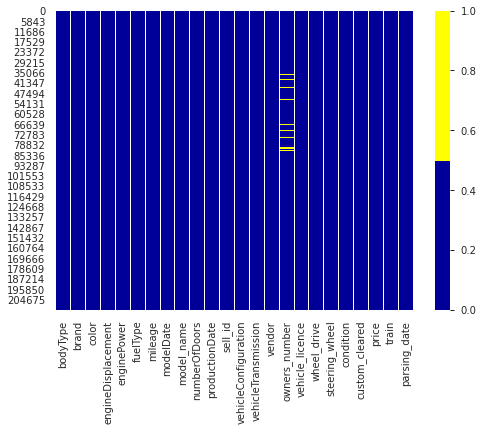

In [59]:
colours = ['#000099', '#ffff00'] 
sns.heatmap(all_data.isna(), cmap=sns.color_palette(colours))

In [60]:
for col in all_data.columns:
    pct_missing = np.mean(all_data[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

bodyType - 0.0%
brand - 0.0%
color - 0.0%
engineDisplacement - 0.0%
enginePower - 0.0%
fuelType - 0.0%
mileage - 0.0%
modelDate - 0.0%
model_name - 0.0%
numberOfDoors - 0.0%
productionDate - 0.0%
sell_id - 0.0%
vehicleConfiguration - 0.0%
vehicleTransmission - 0.0%
vendor - 0.0%
owners_number - 5.0%
vehicle_licence - 0.0%
wheel_drive - 0.0%
steering_wheel - 0.0%
condition - 0.0%
custom_cleared - 0.0%
price - 0.0%
train - 0.0%
parsing_date - 0.0%


In [61]:
all_data[all_data.train == 1].dropna(inplace=True)

In [62]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169425 entries, 0 to 214193
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   bodyType              169423 non-null  object        
 1   brand                 169425 non-null  object        
 2   color                 169425 non-null  object        
 3   engineDisplacement    169332 non-null  float64       
 4   enginePower           169423 non-null  float64       
 5   fuelType              169424 non-null  object        
 6   mileage               169425 non-null  float64       
 7   modelDate             169423 non-null  float64       
 8   model_name            169425 non-null  object        
 9   numberOfDoors         169423 non-null  float64       
 10  productionDate        169425 non-null  float64       
 11  sell_id               169425 non-null  int64         
 12  vehicleConfiguration  169423 non-null  object        
 13 

In [63]:
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'numberOfDoors', 'owners_number', 'wheel_drive']
num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'modelDate', 'productionDate']
bin_cols = ['condition', 'custom_cleared', 'steering_wheel', 'vehicleTransmission', 'vendor', 'vehicle_licence']
help_cols = ['train', 'sell_id', 'parsing_date']
target_cols = ['price']

all_cols = cat_cols + num_cols + bin_cols + help_cols + target_cols
len(all_cols)

23

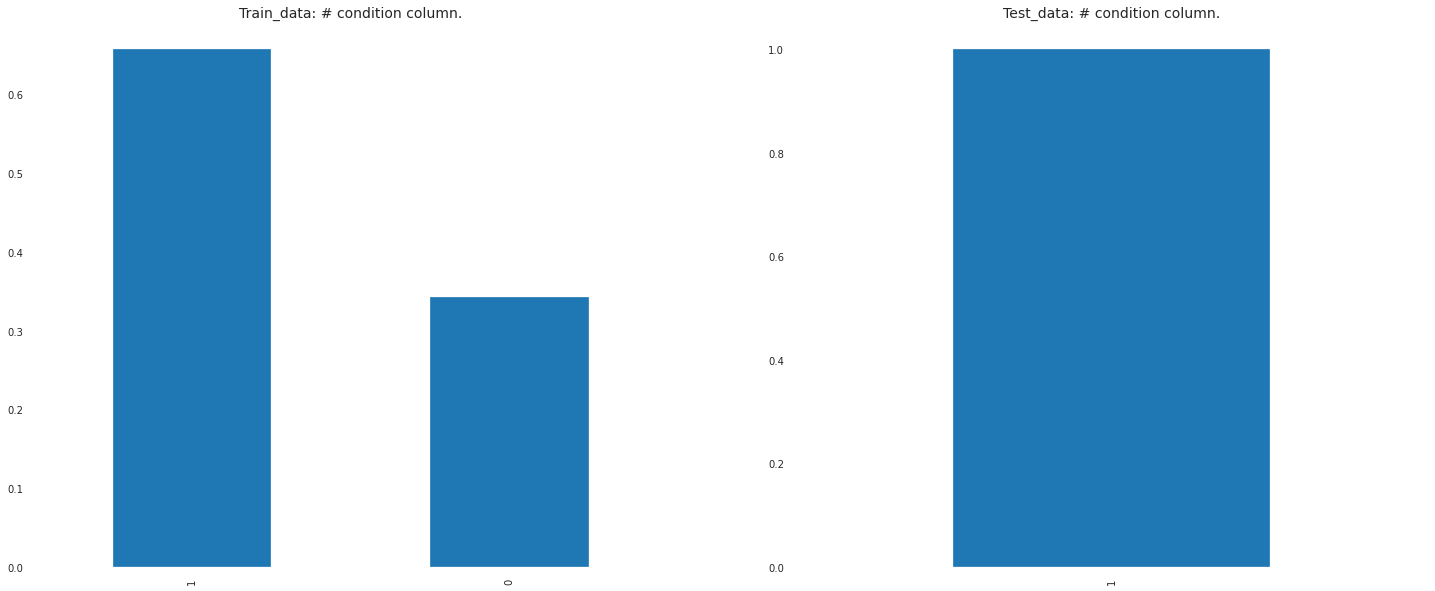

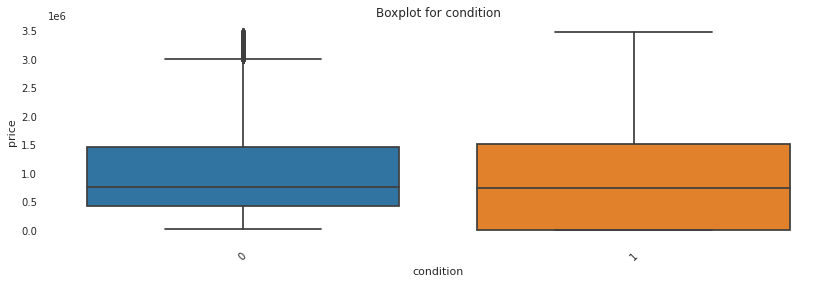

______________________________________________________________________________________________________________________________________________________




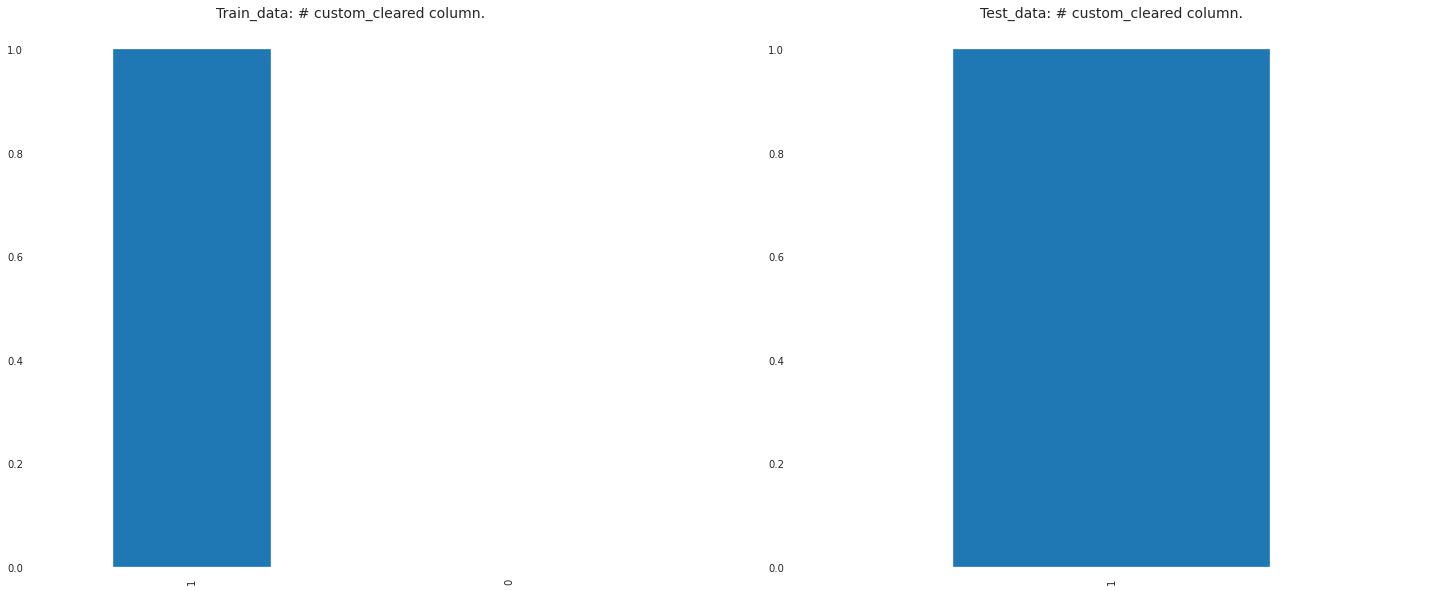

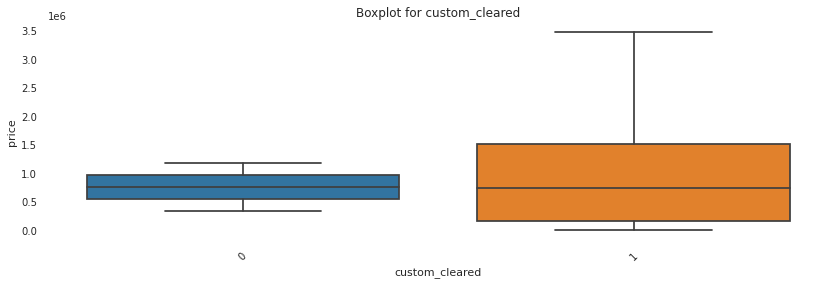

______________________________________________________________________________________________________________________________________________________




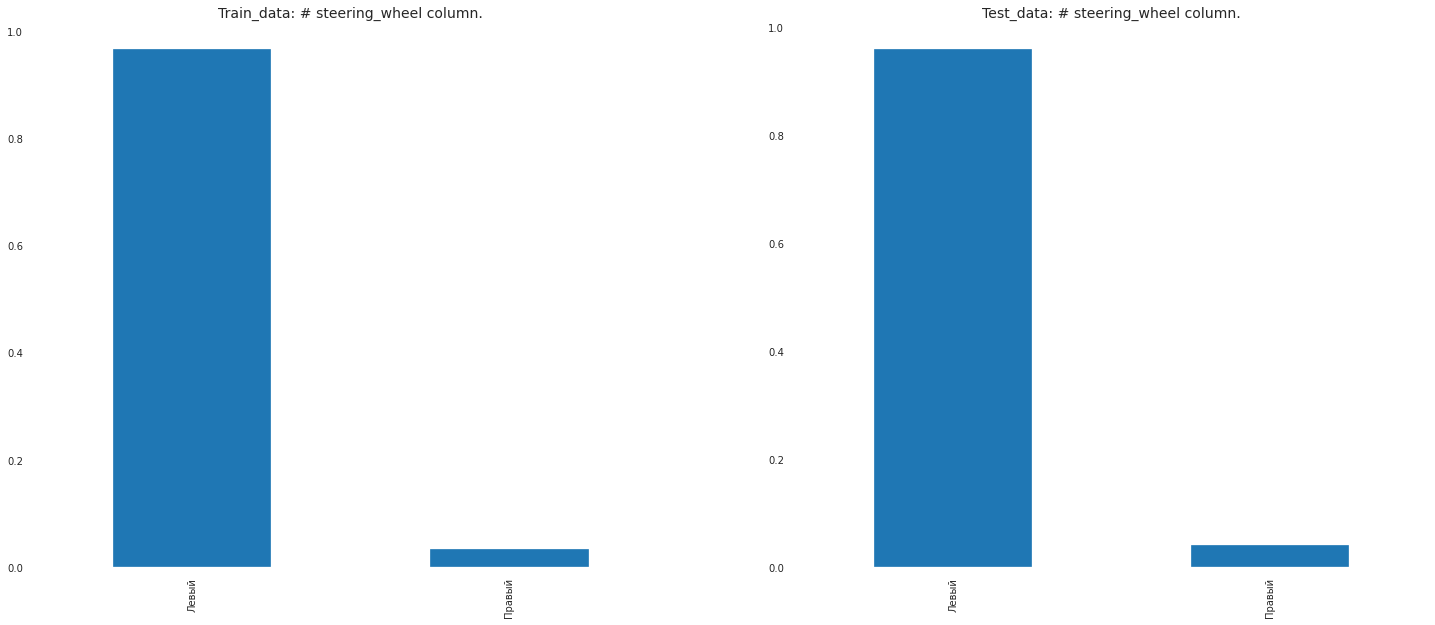

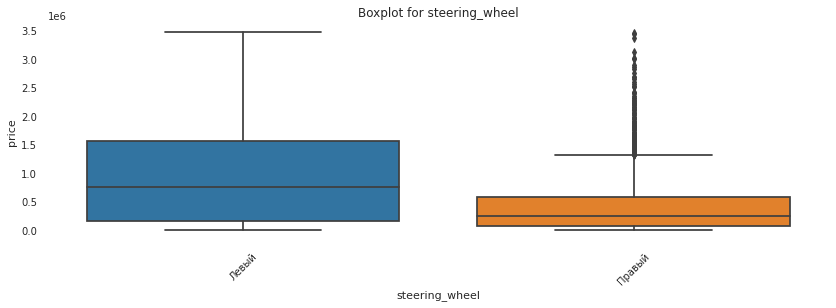

______________________________________________________________________________________________________________________________________________________




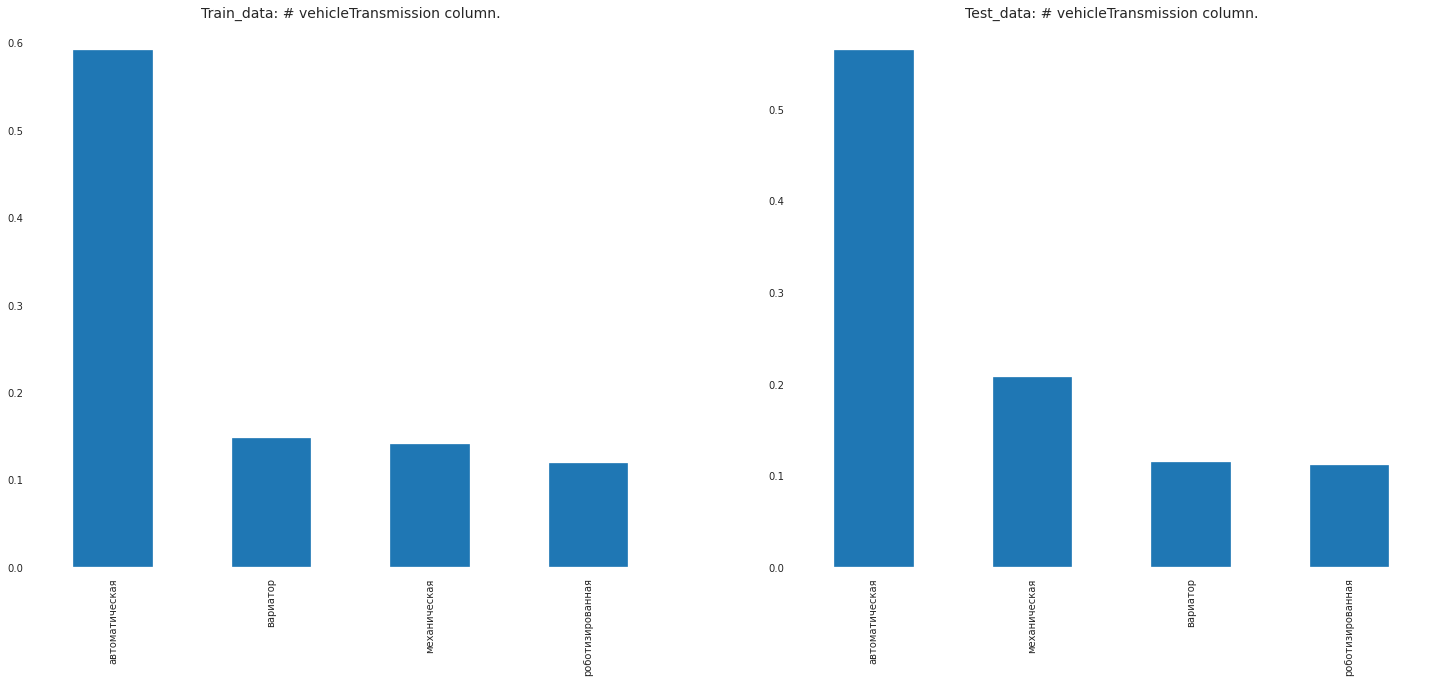

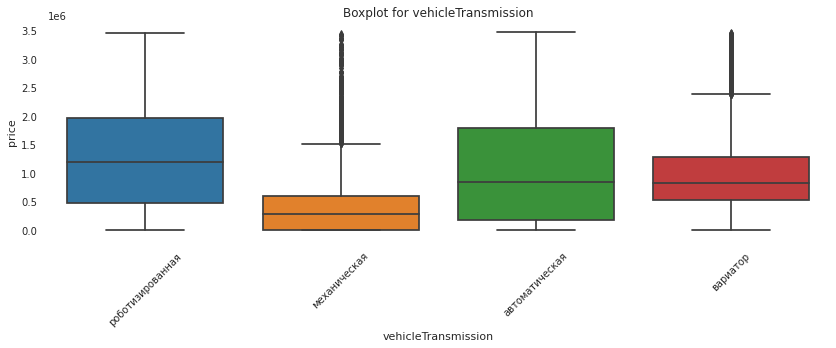

______________________________________________________________________________________________________________________________________________________




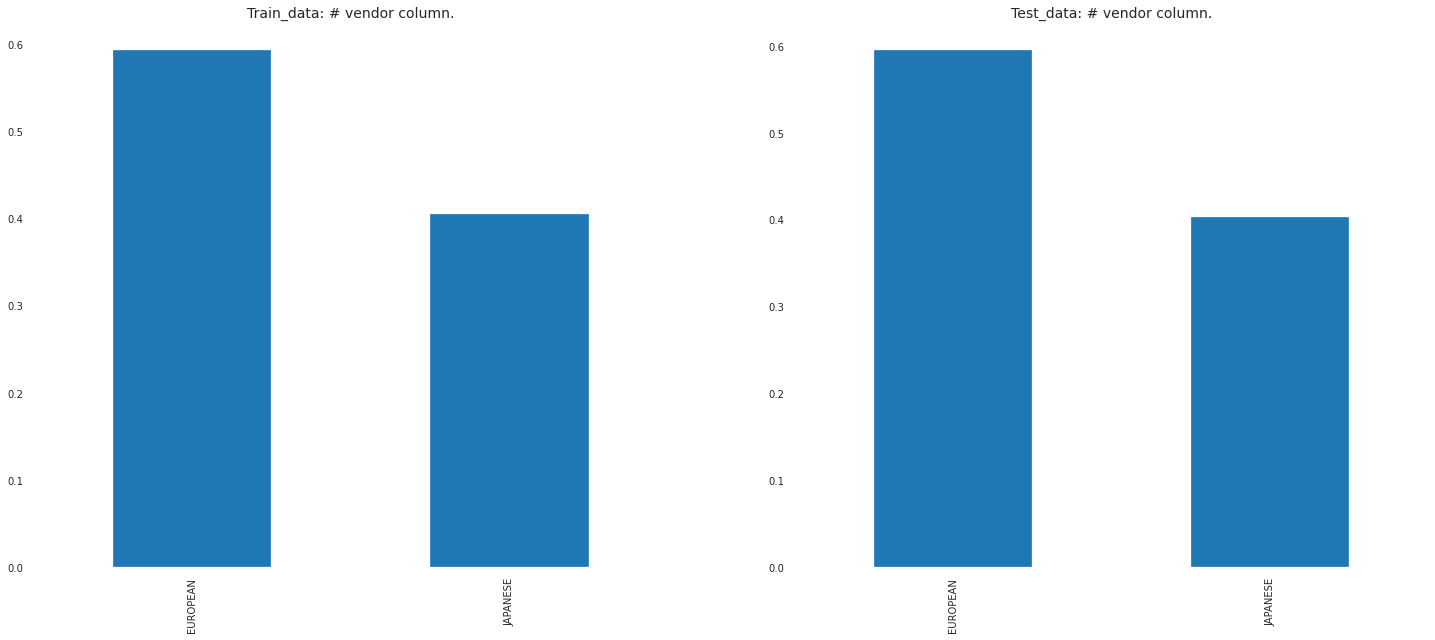

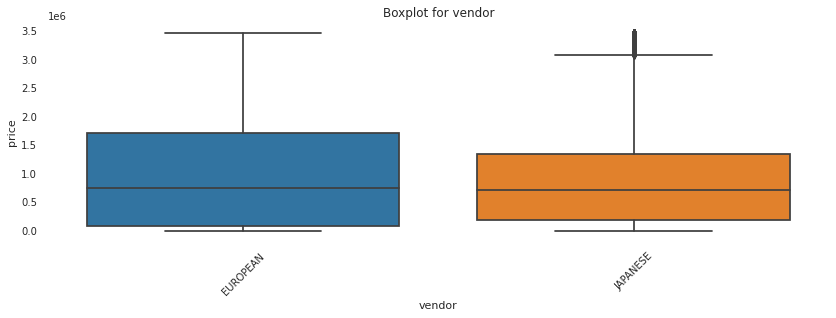

______________________________________________________________________________________________________________________________________________________




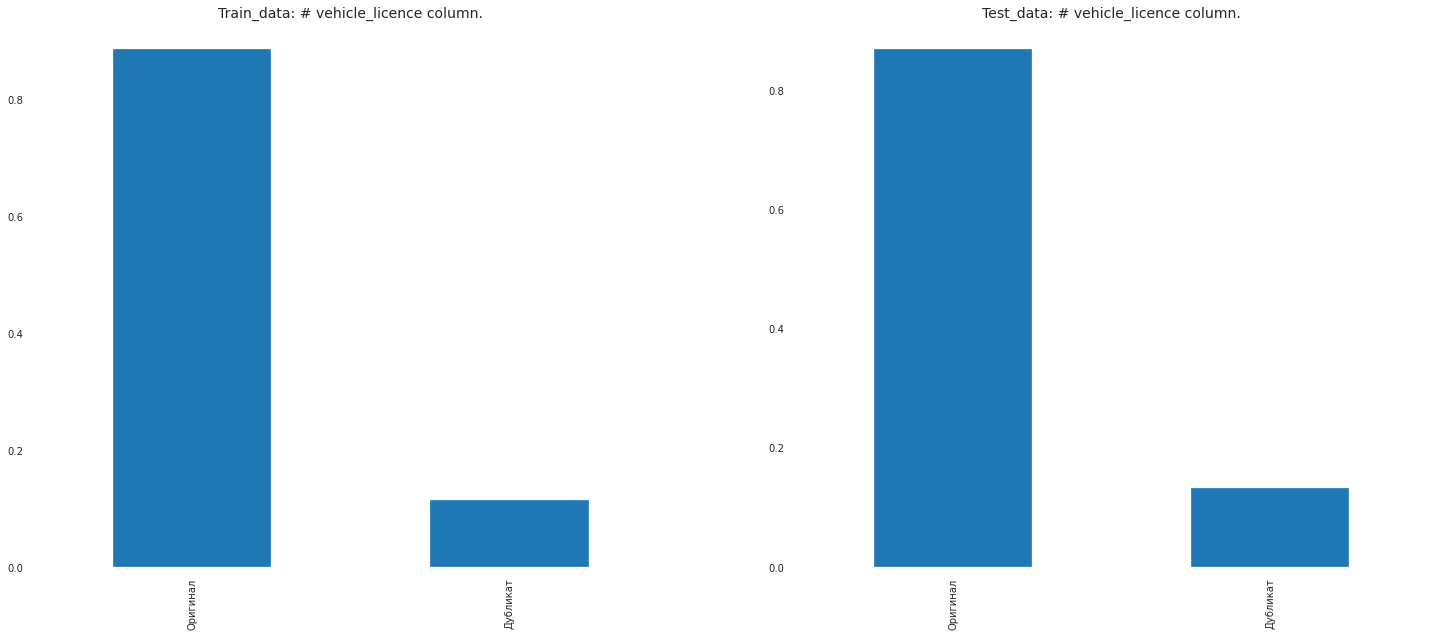

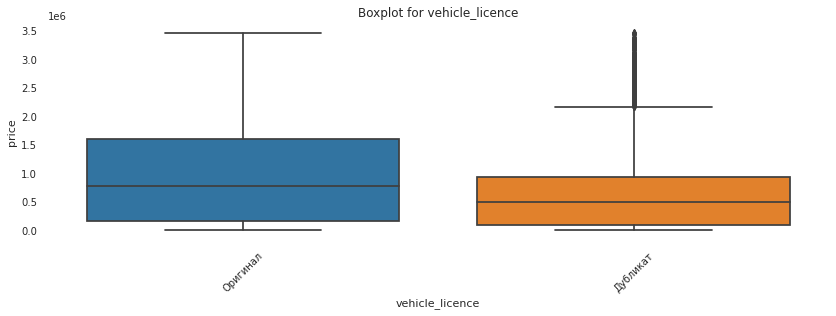

______________________________________________________________________________________________________________________________________________________




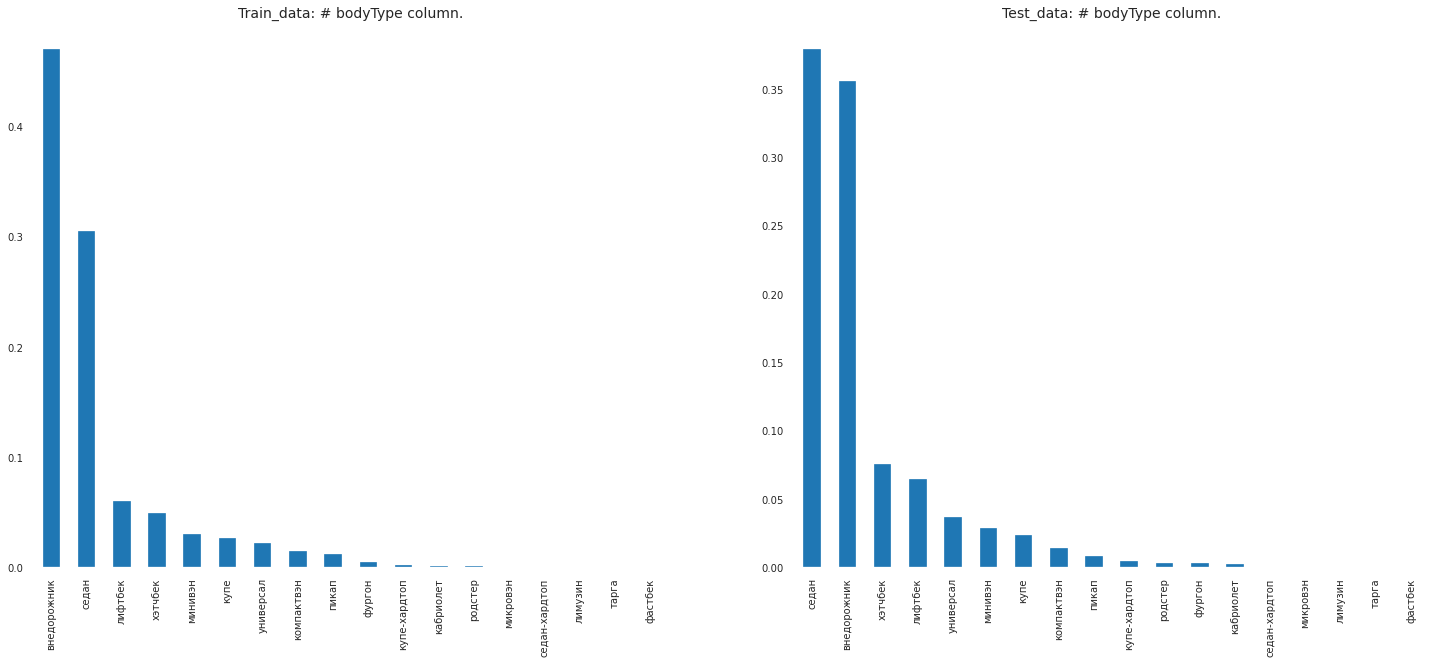

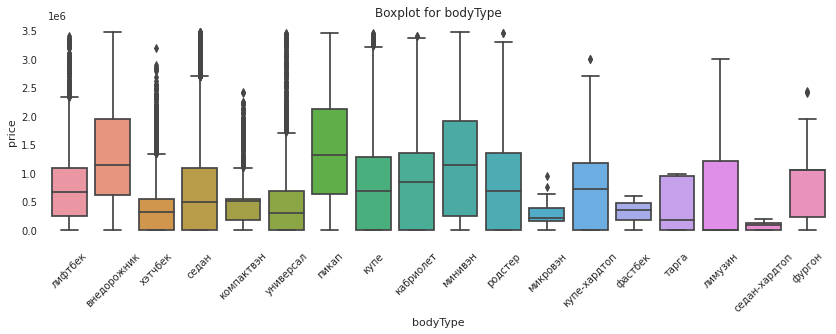

______________________________________________________________________________________________________________________________________________________




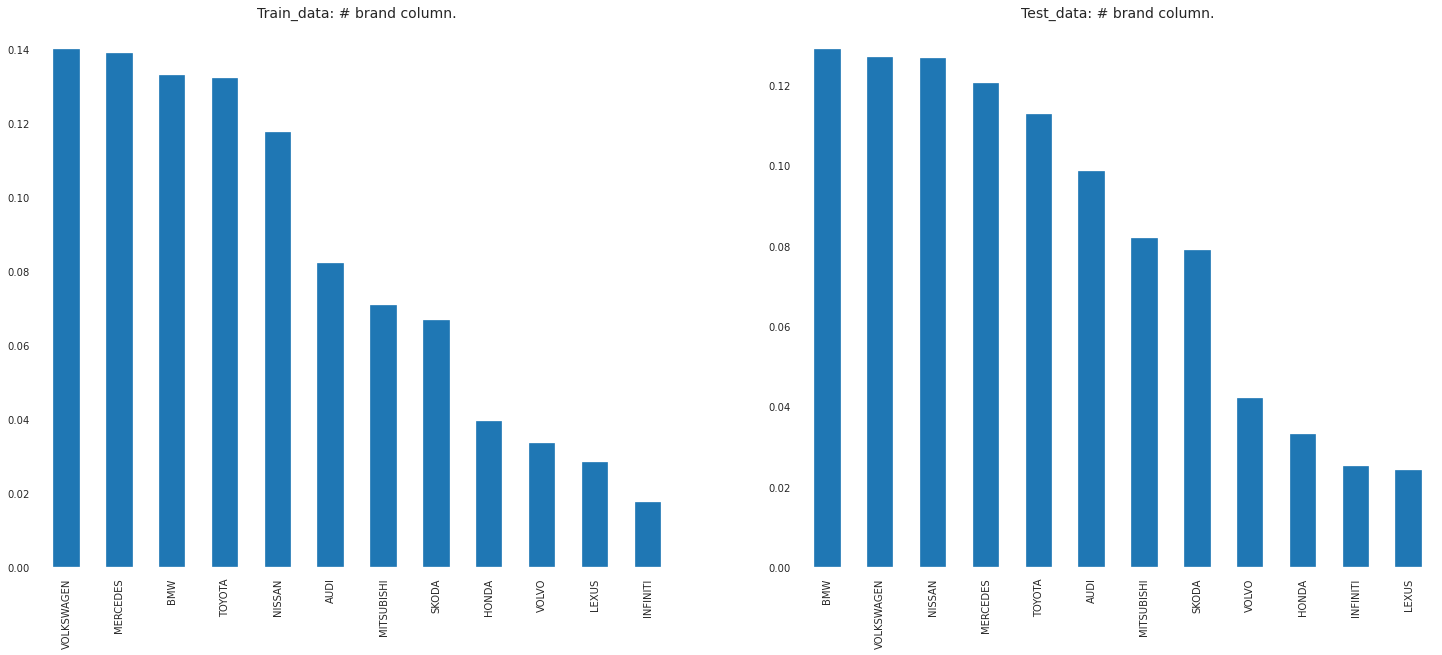

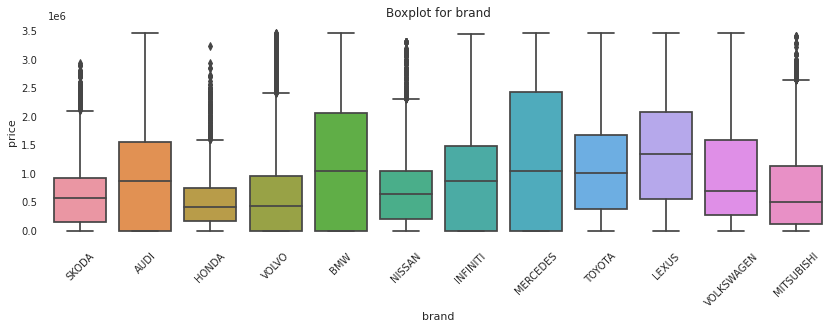

______________________________________________________________________________________________________________________________________________________




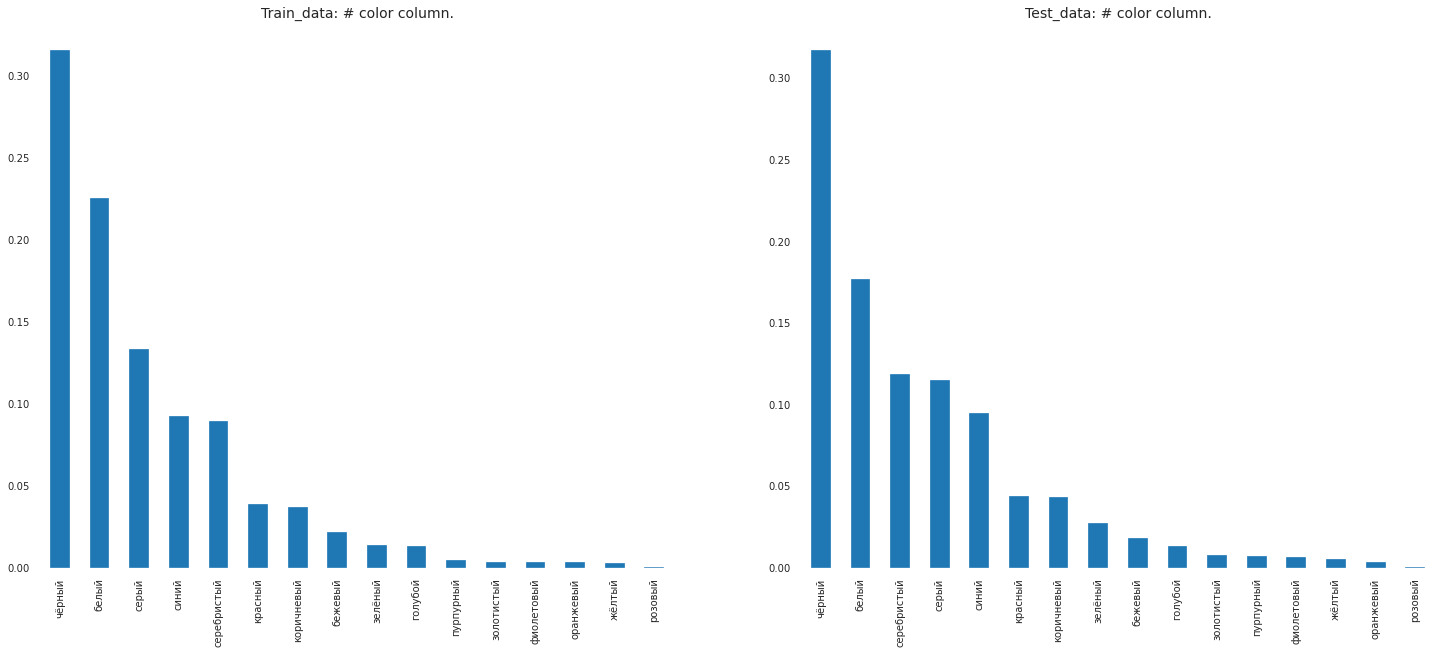

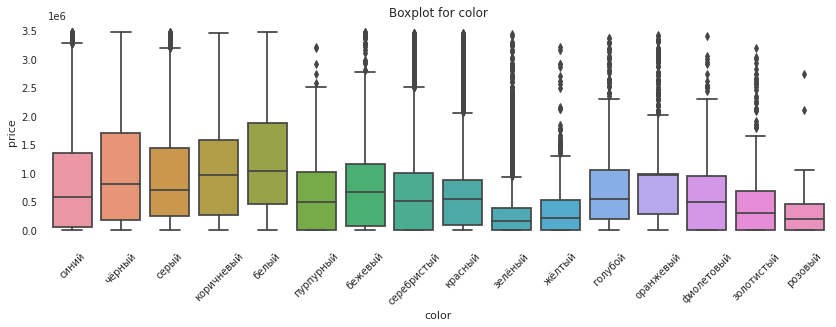

______________________________________________________________________________________________________________________________________________________




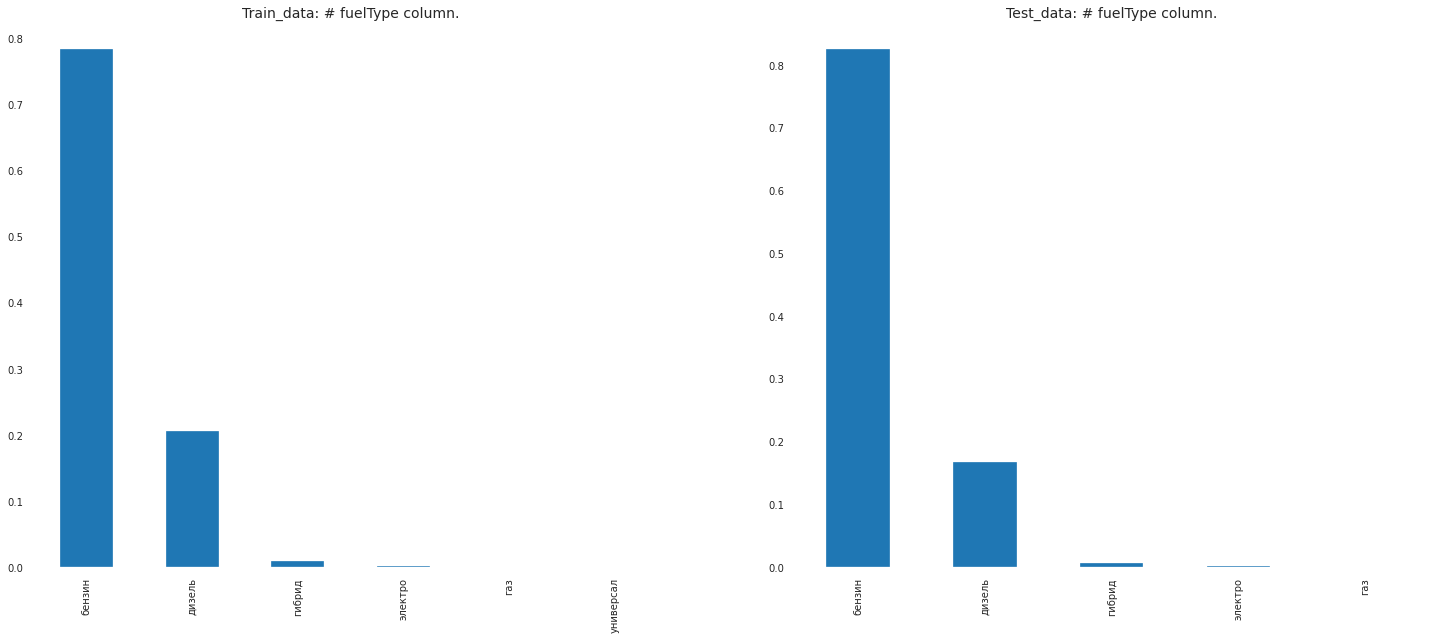

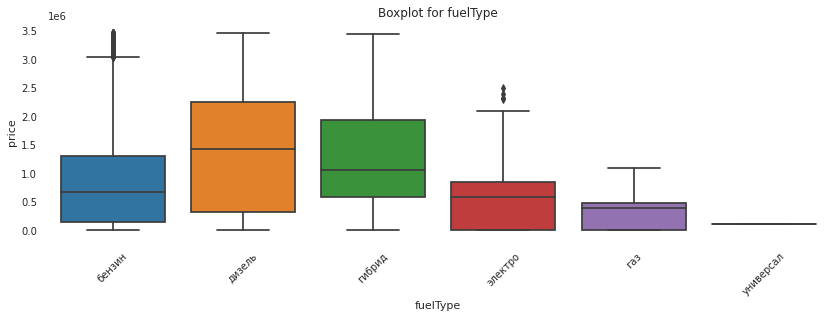

______________________________________________________________________________________________________________________________________________________




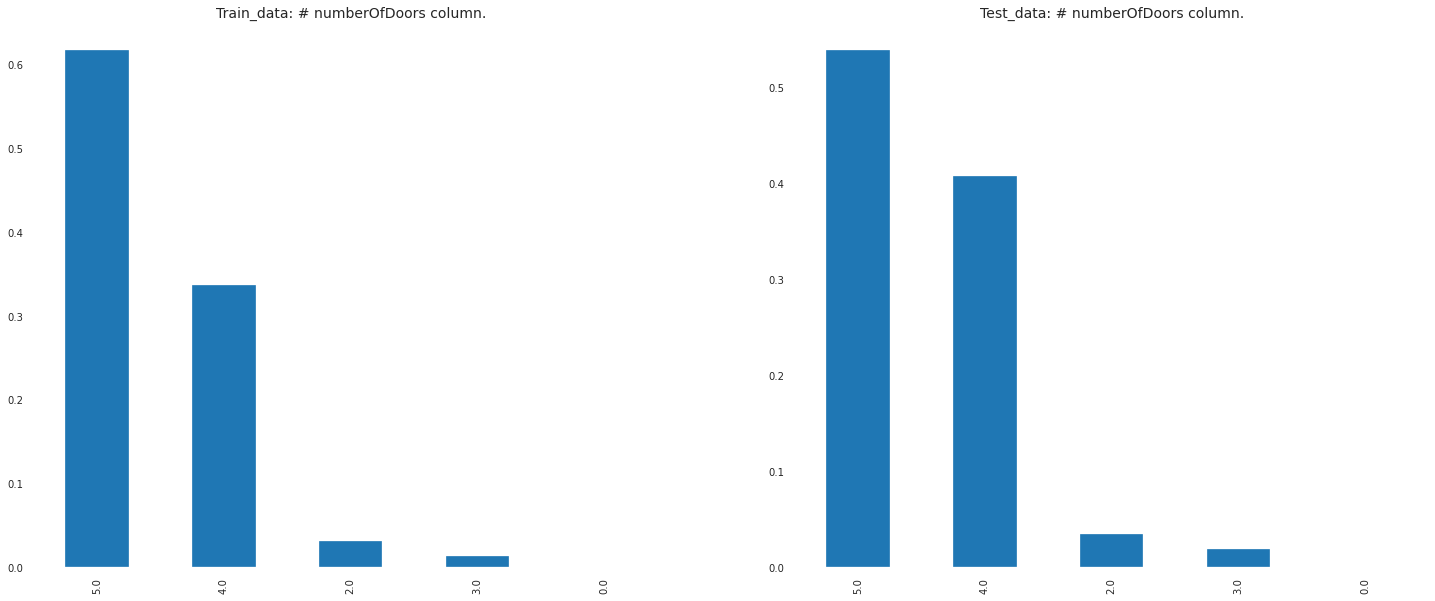

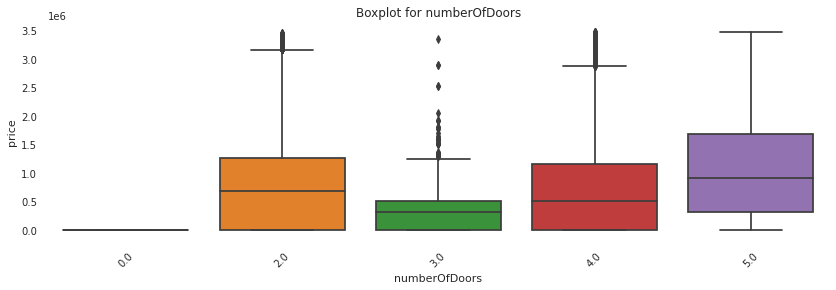

______________________________________________________________________________________________________________________________________________________




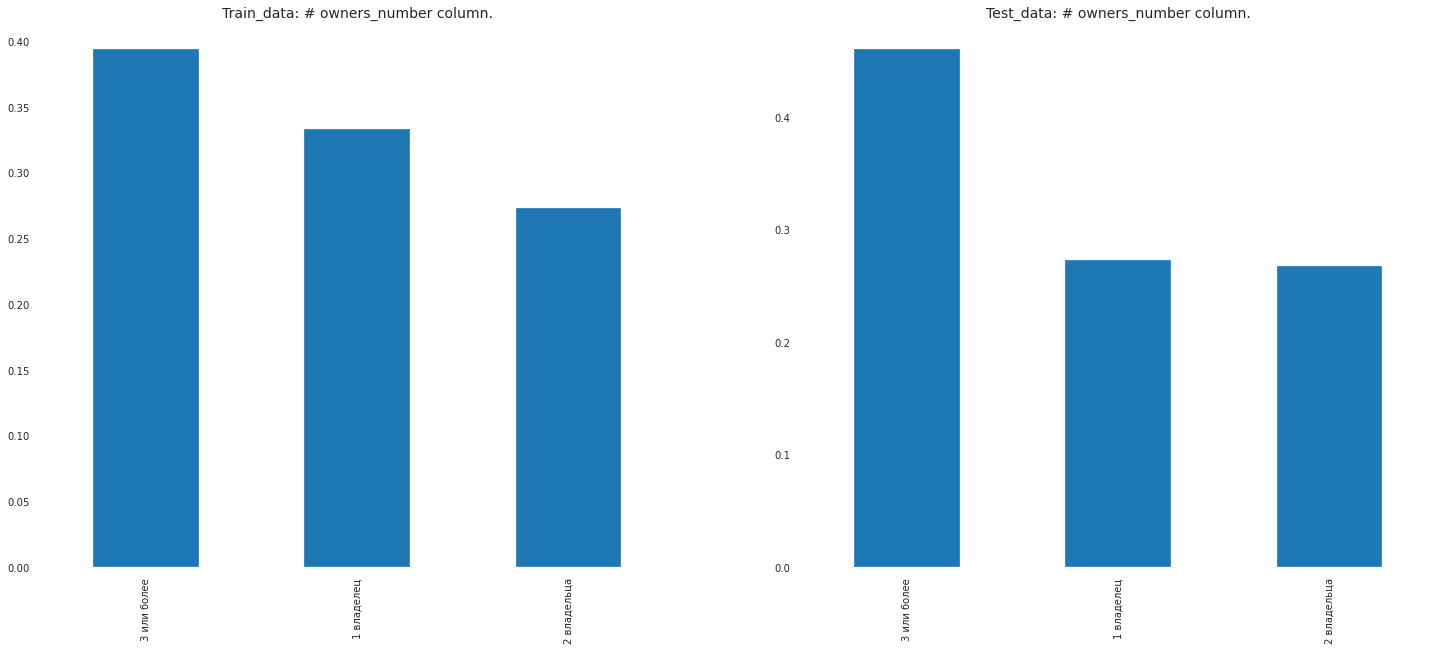

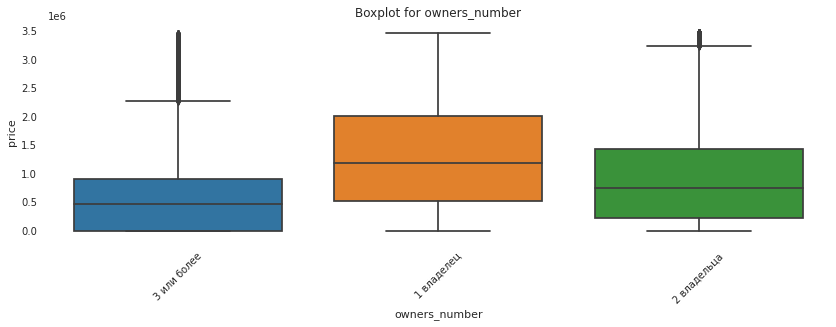

______________________________________________________________________________________________________________________________________________________




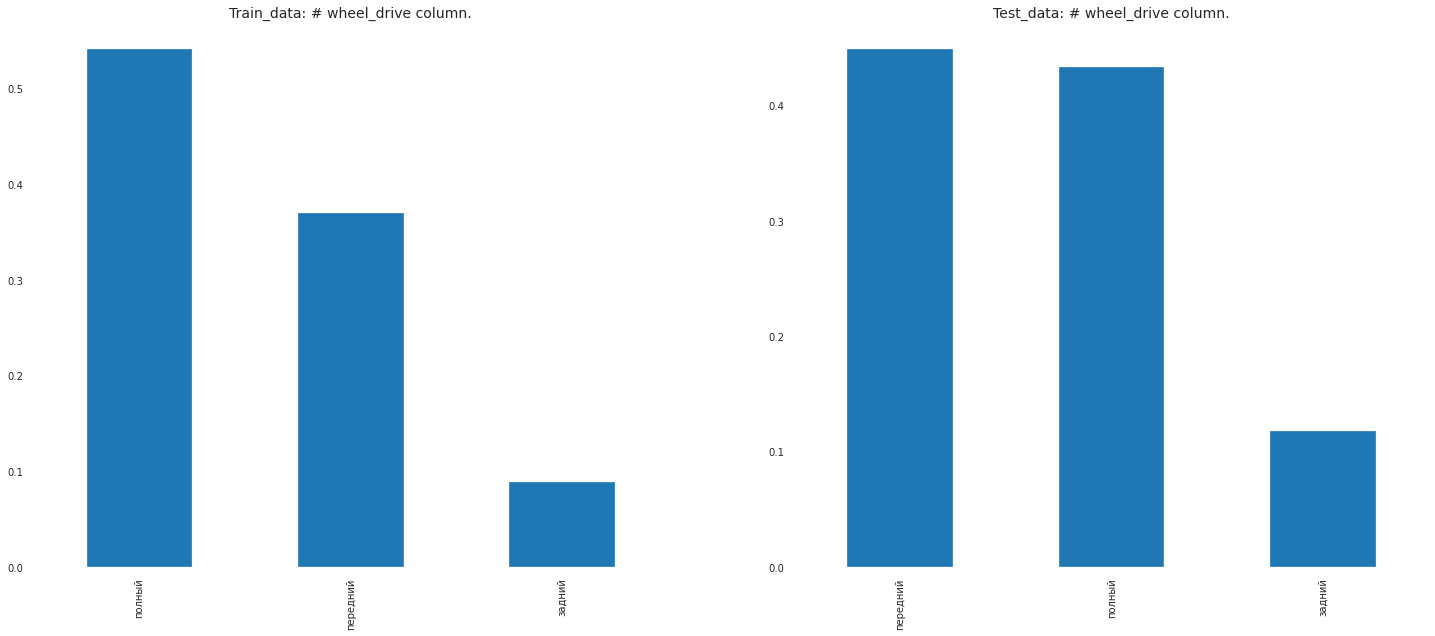

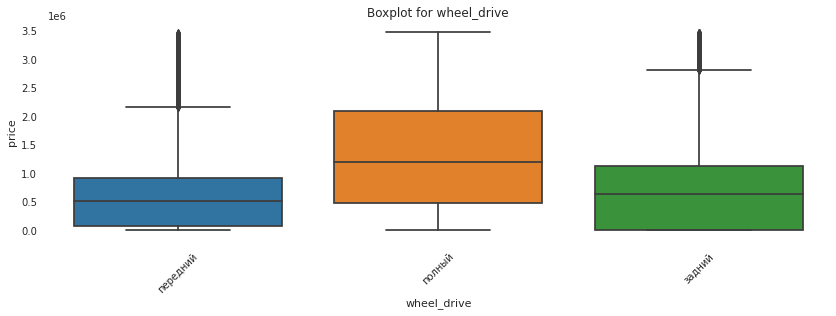

______________________________________________________________________________________________________________________________________________________




In [64]:
for col in bin_cols + cat_cols:
    if col not in ['model_name']: 
        fig, ax = plt.subplots(figsize=(25, 10), ncols=2, nrows=1)
        ax[0].set_title(f'Train_data: # {col} column.', fontdict={'fontsize': 14})
        all_data[all_data.train == 1][col].value_counts(normalize=True).plot(kind='bar', ax=ax[0])
        ax[1].set_title(f'Test_data: # {col} column.', fontdict={'fontsize': 14})
        all_data[all_data.train == 0][col].value_counts(normalize=True).plot(kind='bar', ax=ax[1])
        # из-за выбросов в price нужно взять 90% квантиль, чтобы боксплоты были читаемы
        show_boxplot(data=all_data[all_data.price <= all_data.price.quantile(0.9)], column=col, target_column='price')
        print('_' * 150)
        print('\n')
        plt.show()

Выводы:
1. колонки 'condition', 'custom_cleared' имеют по одному уникальному значению в тесте и трейне, для модели они бесполезны
2. 'bodyType', 'color', 'fuelType', 'numberOfDoors' сильный перевес в сторону определённых двух позиций

In [65]:
all_data.drop('condition', axis=1, inplace=True)
all_data.drop('custom_cleared', axis=1, inplace=True)


In [66]:
bin_cols.remove('condition')
bin_cols.remove('custom_cleared')

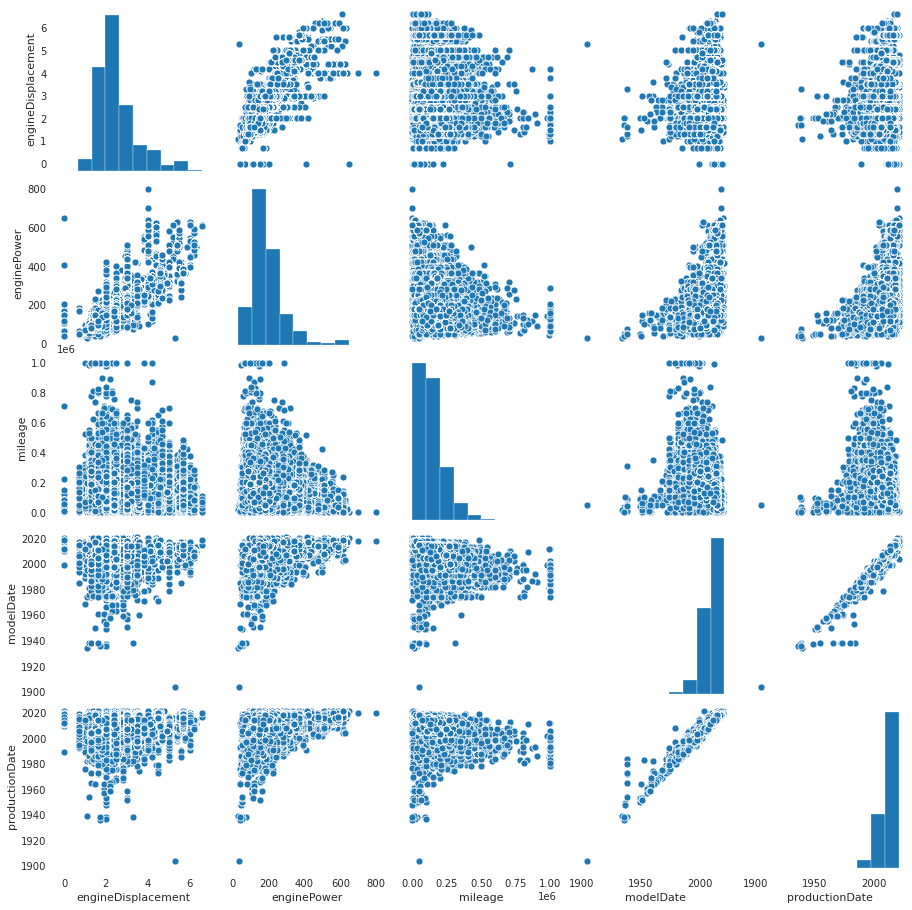

In [67]:
sns.pairplot(all_data[num_cols])

In [68]:
all_data[num_cols].describe()

engineDisplacement    enginePower         mileage      modelDate  \
count       169332.000000  169423.000000   169425.000000  169423.000000   
mean             2.452753     199.183759   132345.443884    2009.745678   
std              0.971620      95.849596    97673.346047       7.171285   
min              0.000000      30.000000        0.000000    1904.000000   
25%              1.800000     140.000000    58600.000000    2006.000000   
50%              2.000000     177.000000   124449.000000    2011.000000   
75%              3.000000     249.000000   183000.000000    2015.000000   
max              6.600000     800.000000  1000000.000000    2021.000000   

       productionDate  
count   169425.000000  
mean      2011.858073  
std          6.877108  
min       1904.000000  
25%       2008.000000  
50%       2013.000000  
75%       2017.000000  
max       2021.000000

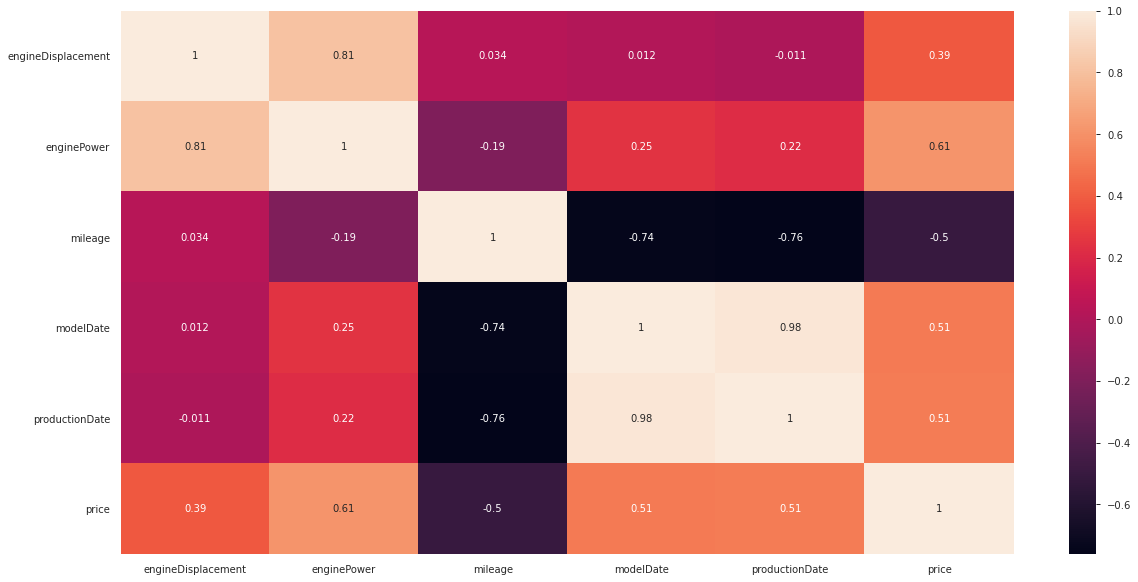

In [69]:
plt.figure(figsize=(20, 10));
sns.heatmap(all_data[all_data.train == 1][num_cols + ['price']].corr(), annot=True);

Сильно коррелируются между собой 'engineDisplacement' и 'enginePower', 'mileage' и 'modelDate','mileage' и 'productionDate', 'modelDate' и 'productionDate'. Нужно будет удалить по одному из них, но после добавления фич.

In [70]:
for column in num_cols:
    print(column)
    print(outliers(all_data, column))

engineDisplacement
                    left   right
borders     2.220446e-16     4.8
# outliers  1.300000e+02  5261.0
enginePower
            left   right
borders    -23.5   412.5
# outliers   0.0  5620.0
mileage
                left     right
borders    -128000.0  369600.0
# outliers       0.0    3981.0
modelDate
              left   right
borders     1992.5  2028.5
# outliers  5081.0     0.0
productionDate
              left   right
borders     1994.5  2030.5
# outliers  4372.0     0.0


Выбросы в каждой колонке

In [71]:
all_data.query('train == 1').enginePower.describe(), all_data.query('train == 0').enginePower.describe()

(count    134737.000000
 mean        202.012870
 std          97.314289
 min          30.000000
 25%         143.000000
 50%         180.000000
 75%         249.000000
 max         800.000000
 Name: enginePower, dtype: float64,
 count    34686.000000
 mean       188.194142
 std         89.087035
 min         30.000000
 25%        125.000000
 50%        169.000000
 75%        233.000000
 max        639.000000
 Name: enginePower, dtype: float64)

в трейне немного больше максимальное значение

In [72]:
all_data[(all_data.train == 1) & (all_data.enginePower > all_data.query('train == 0').enginePower.max())]

bodyType     brand   color  engineDisplacement  enginePower  \
79243  внедорожник  MERCEDES  чёрный                 4.0        700.0   
79310  внедорожник  MERCEDES  чёрный                 4.0        800.0   
94703        седан      AUDI   серый                 0.0        646.0   

      fuelType  mileage  modelDate    model_name  numberOfDoors  ...  \
79243   бензин      0.0     2018.0  G_KLASSE_AMG            5.0  ...   
79310   бензин      0.0     2018.0  G_KLASSE_AMG            5.0  ...   
94703  электро    250.0     2020.0  RS e-tron GT            4.0  ...   

                   vehicleConfiguration  vehicleTransmission    vendor  \
79243  ALLROAD_5_DOORS AUTOMATIC Brabus       автоматическая  EUROPEAN   
79310  ALLROAD_5_DOORS AUTOMATIC Brabus       автоматическая  EUROPEAN   
94703                   SEDAN AUTOMATIC       автоматическая  EUROPEAN   

      owners_number vehicle_licence wheel_drive steering_wheel       price  \
79243           NaN             NaN      полный          Левый  29300000.0   
79310           NaN             NaN      полный          Левый  31600000.0   
94703    1 владелец        Оригинал      полный          Левый  16006200.0   

      train  parsing_date  
79243     1    2020-09-09  
79310     1    2020-09-09  
94703     1    2021-09-26  

[3 rows x 22 columns]

In [73]:
all_data.drop(all_data[(all_data.train == 1) & 
             (all_data.enginePower > all_data.query('train == 0').enginePower.max())].index, inplace=True)

In [74]:
all_data.query('train == 1').mileage.describe(), all_data.query('train == 0').mileage.describe()

(count     134736.000000
 mean      124711.701186
 std        95403.429991
 min            0.000000
 25%        50470.250000
 50%       115000.000000
 75%       176929.000000
 max      1000000.000000
 Name: mileage, dtype: float64,
 count      34686.000000
 mean      162009.767889
 std       100676.559489
 min            1.000000
 25%        91153.500000
 50%       149779.500000
 75%       215000.000000
 max      1000000.000000
 Name: mileage, dtype: float64)

In [75]:
all_data.query('train == 1').productionDate.describe(), all_data.query('train == 0').productionDate.describe()

(count    134736.000000
 mean       2012.525539
 std           6.671280
 min        1904.000000
 25%        2009.000000
 50%        2014.000000
 75%        2018.000000
 max        2021.000000
 Name: productionDate, dtype: float64,
 count    34686.000000
 mean      2009.264602
 std          7.047661
 min       1904.000000
 25%       2006.000000
 50%       2011.000000
 75%       2014.000000
 max       2020.000000
 Name: productionDate, dtype: float64)

"Не старые, а раритетные!"

Опытным путём было опробовано добавить множетсво новых признаков, оставлены лишь те, которые положительно влияли на результат работы модели

In [76]:
all_data['engineDisplacement_cat'] = all_data['engineDisplacement'].apply(lambda x: 1 if 0 <= x <=1.1 
                                                                                  else 2 if 1.2 <= x <= 1.7
                                                                                    else 3 if 1.8 <= x <= 3.5 
                                                                                      else 4)
all_data['enginePower_cat'] = all_data['enginePower'].apply(lambda x: 1 if 0 <= x <= 70 
                                                                    else 2 if 71 <= x <= 100 
                                                                        else 3 if 101 <= x <= 150 
                                                                            else 4 if 151 <= x <= 200
                                                                               else 5)
all_data['mileage_cat'] = all_data['mileage'].apply(lambda x: 1 if 0 <= x <= 100000 
                                                            else 2 if 100001 <= x <= 300000 
                                                                else 3)

cat_cols.extend(['engineDisplacement_cat', 'enginePower_cat', 'mileage_cat'])

In [77]:
all_data['untill_2019'] = all_data.productionDate.apply(lambda x: 1 if x < 2021 - 3 else 0)
all_data['untill_2017'] = all_data.productionDate.apply(lambda x: 1 if x < 2021 - 5 else 0)
all_data['bodyType_pop'] = all_data.bodyType.apply(lambda x: 1 if x in ['внедорожник', 'седан'] else 0)
all_data['bodyType_nopop'] = all_data.bodyType.apply(lambda x: 1 if x in ['микровэн', 'седан-хардтоп', 'лимузин',
                                                                                'тарга', 'фастбек'] else 0)
all_data['colors_pop'] = all_data.color.apply(lambda x: 1 if x in ['черный', 'белый', 'серый', 'синий',
                                                                          'серебристый'] else 0)
all_data['colors_nopop'] = all_data.color.apply(lambda x: 1 if x in ['фиолетовый', 'пурпурный', 'золотистый',
                                                                          'оранжевый', 'жёлтый', 'розовый'] else 0)
all_data['numberOfDoors_pop'] = all_data.numberOfDoors.apply(lambda x: 1 if x in [4, 5] else 0)
bin_cols.extend(['untill_2019', 'untill_2017', 'bodyType_pop','bodyType_nopop', 'colors_pop', 'colors_nopop',
                 'numberOfDoors_pop'])

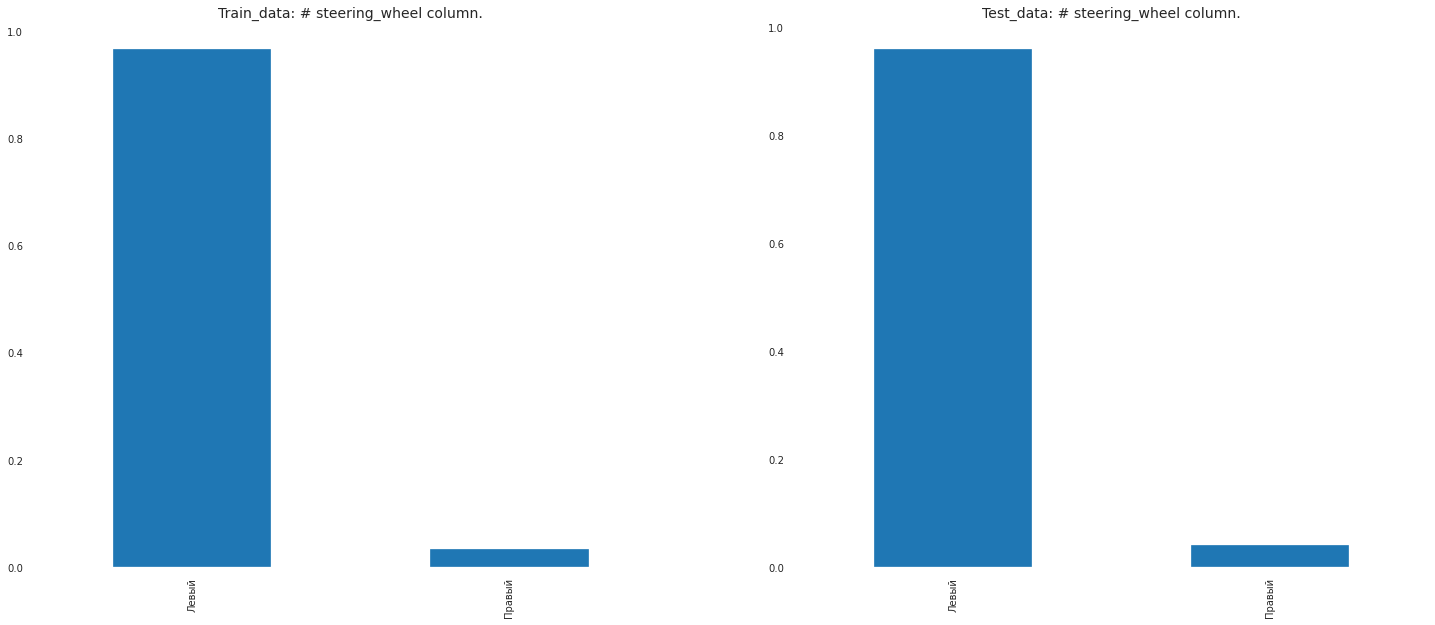

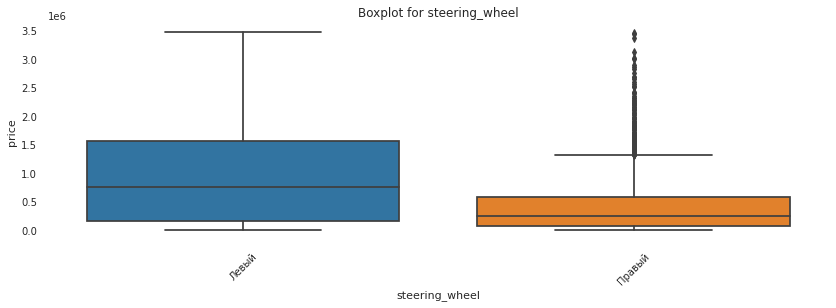

______________________________________________________________________________________________________________________________________________________




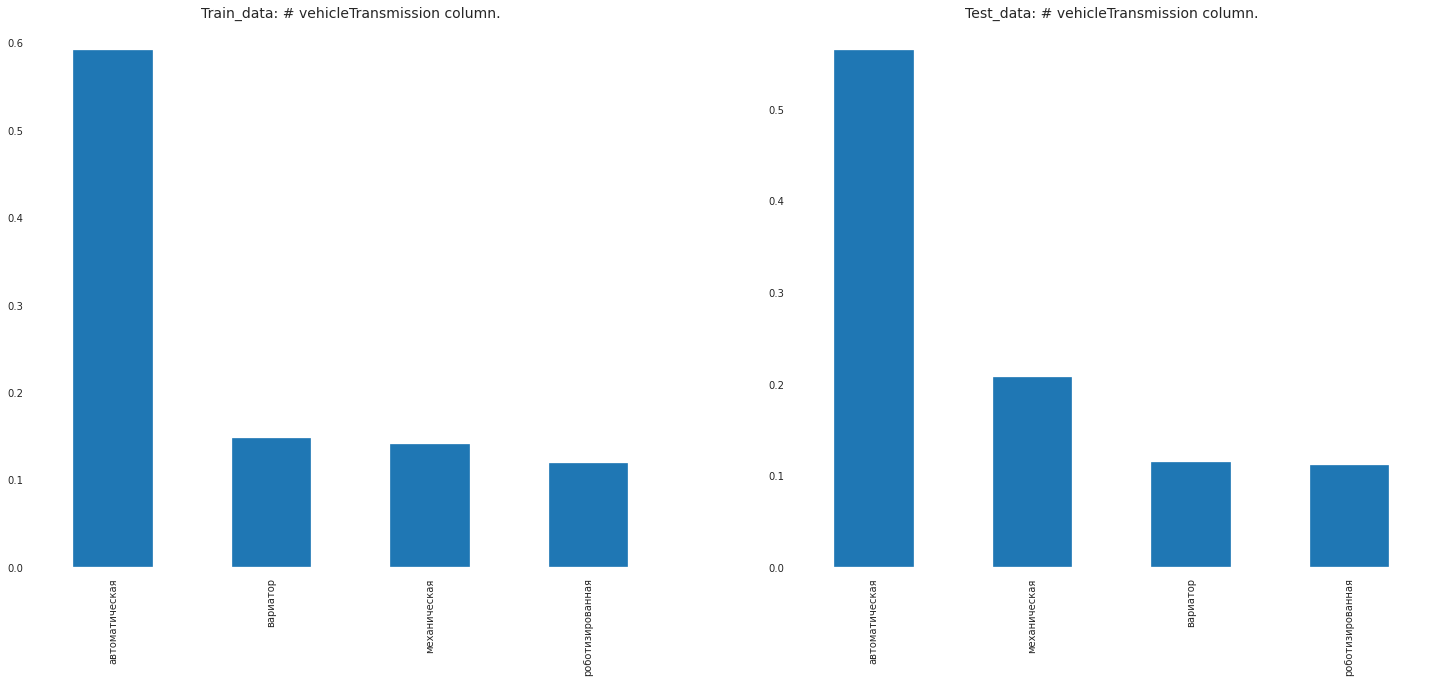

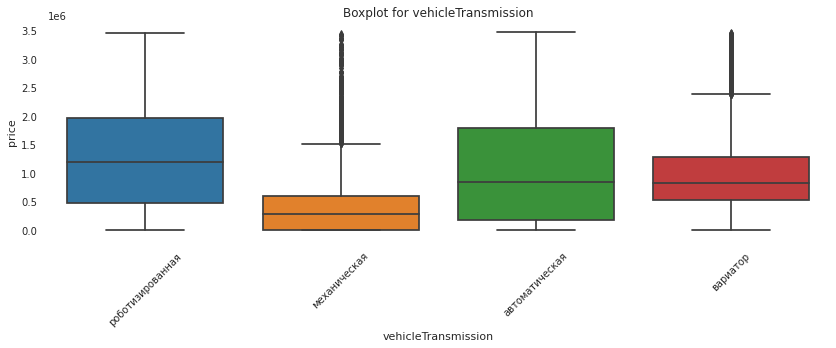

______________________________________________________________________________________________________________________________________________________




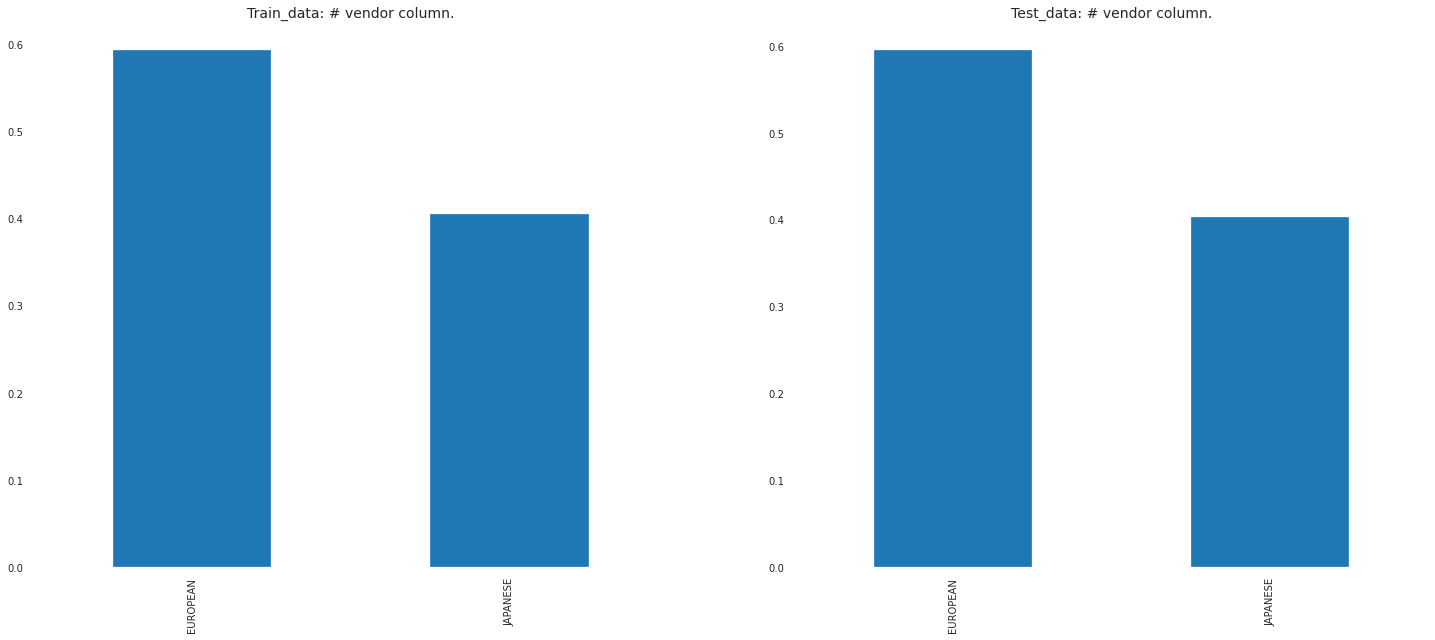

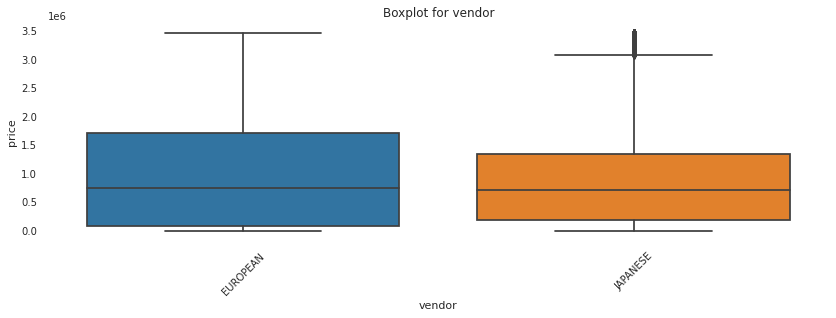

______________________________________________________________________________________________________________________________________________________




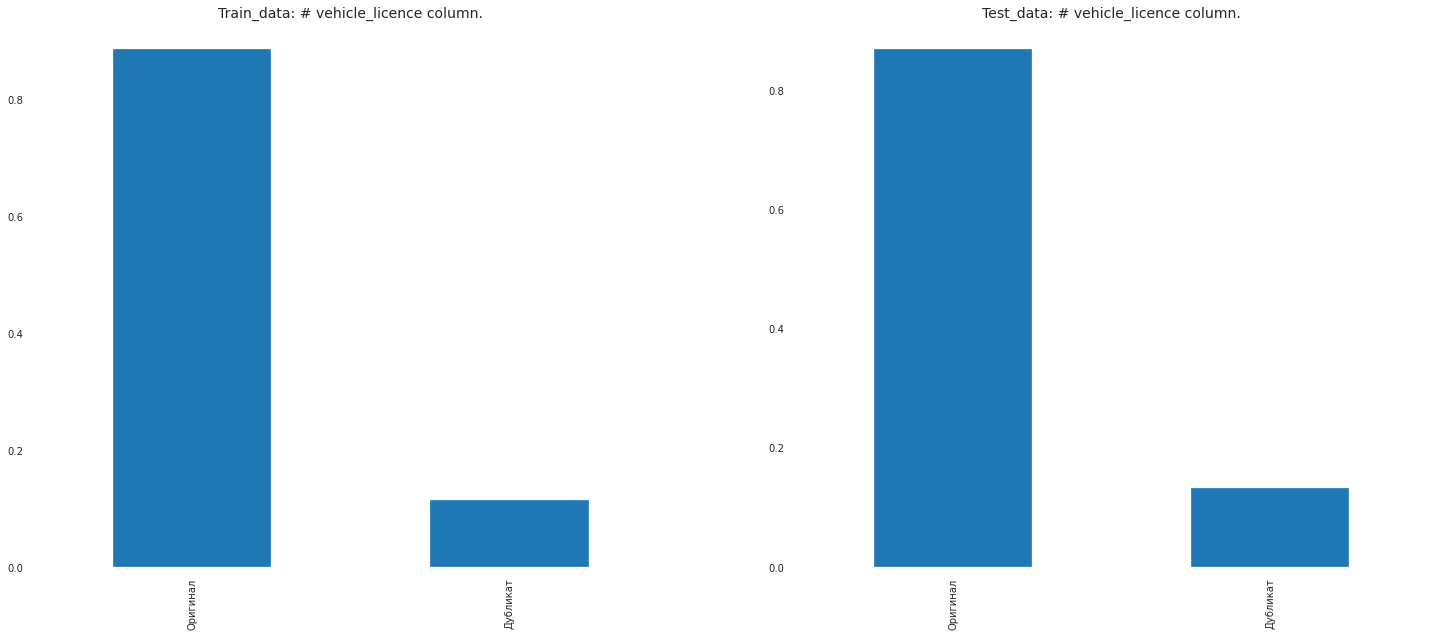

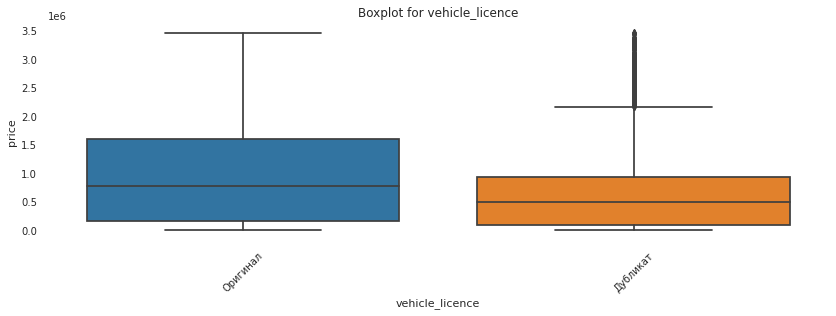

______________________________________________________________________________________________________________________________________________________




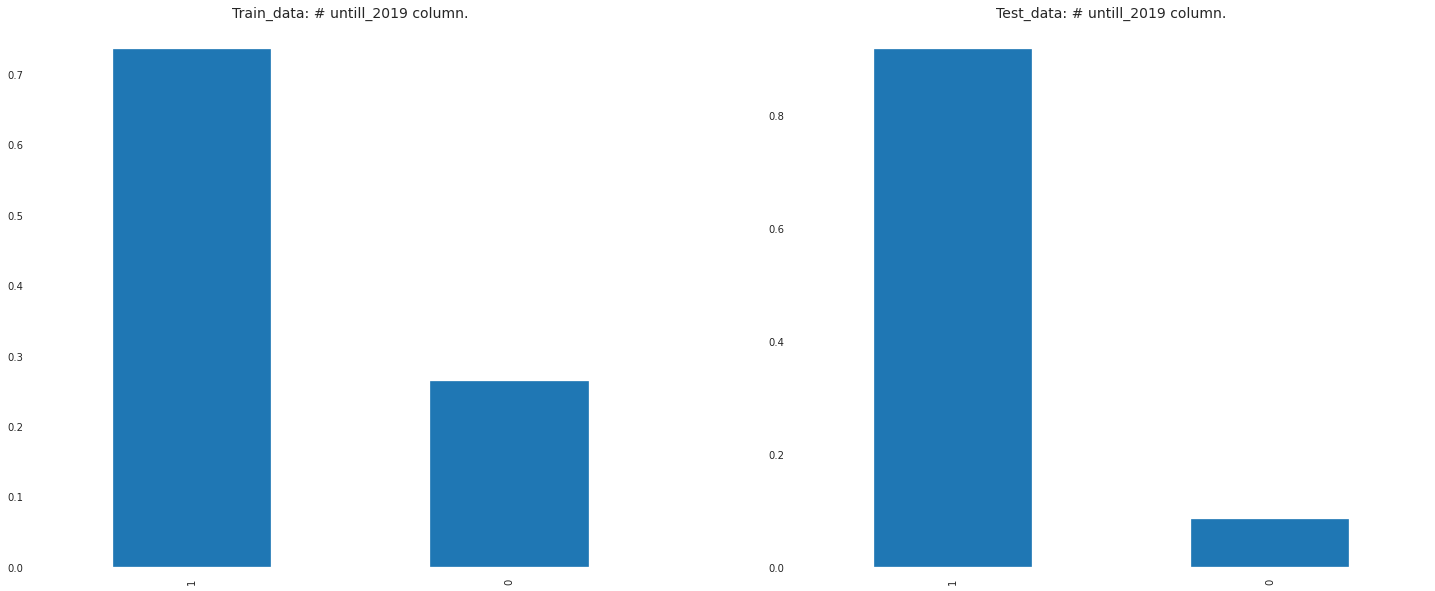

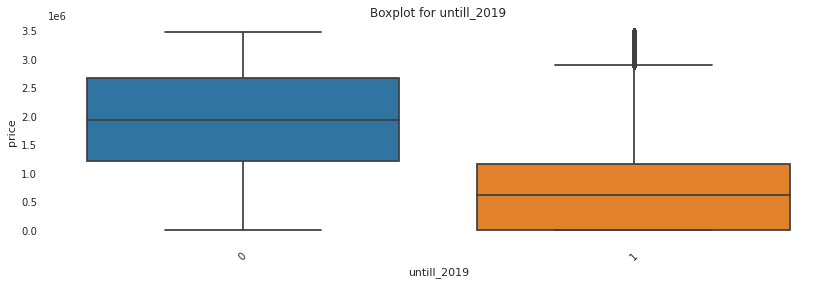

______________________________________________________________________________________________________________________________________________________




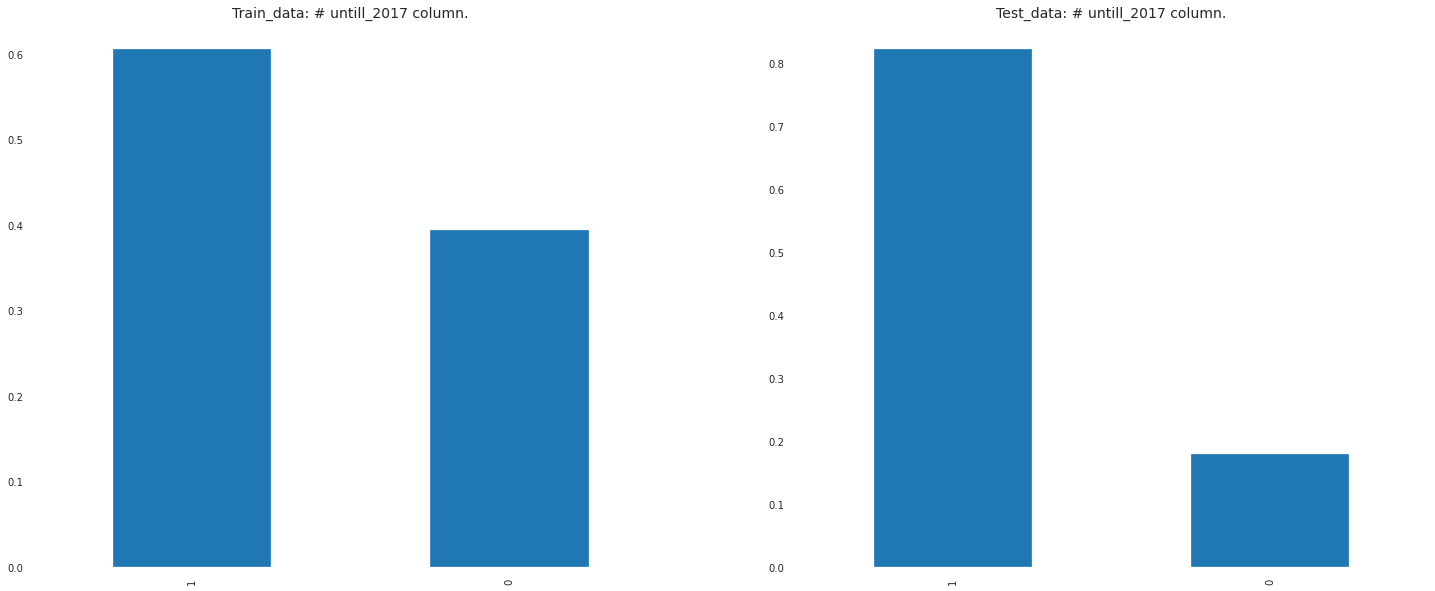

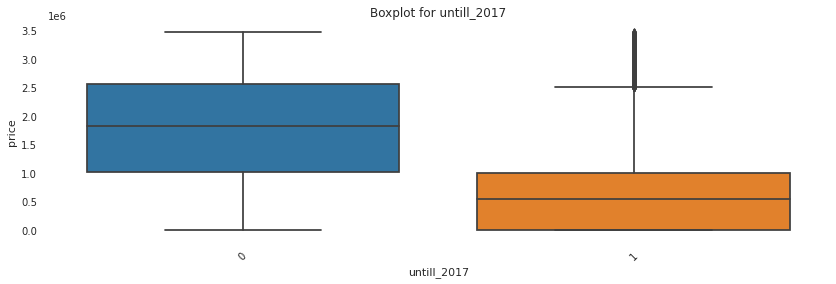

______________________________________________________________________________________________________________________________________________________




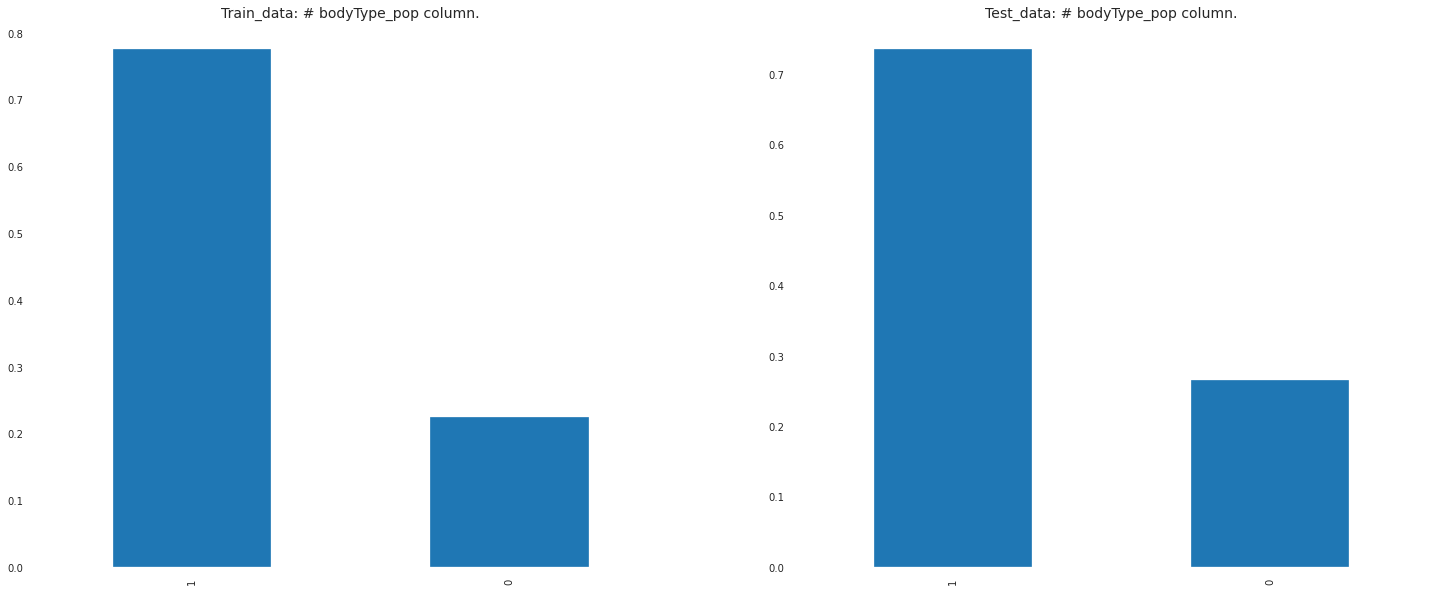

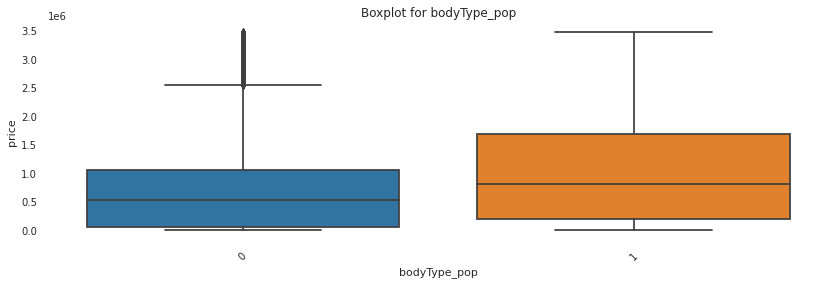

______________________________________________________________________________________________________________________________________________________




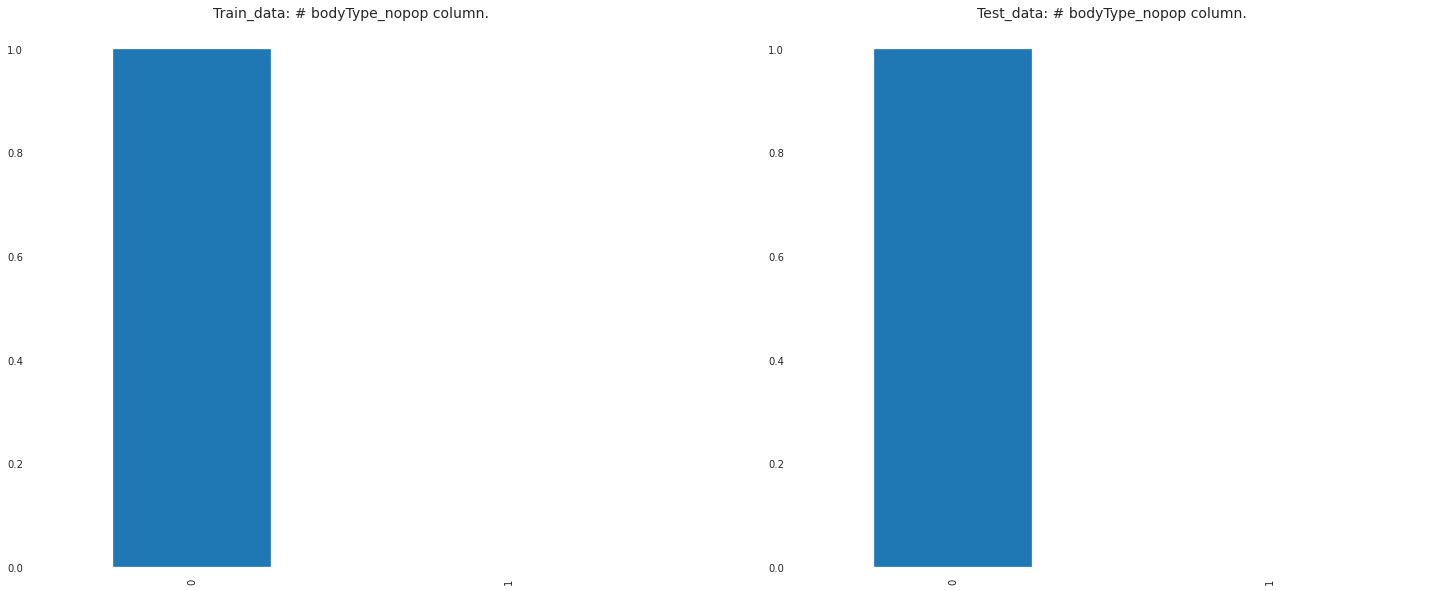

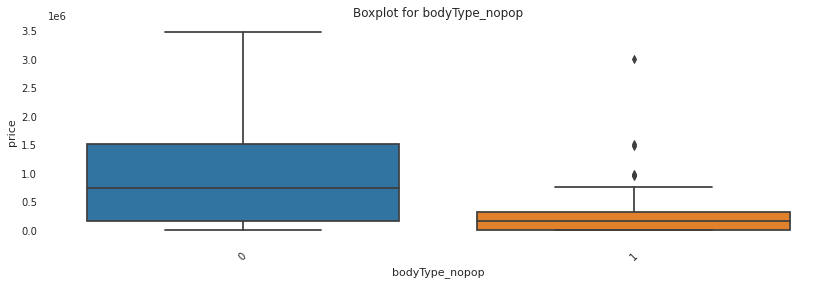

______________________________________________________________________________________________________________________________________________________




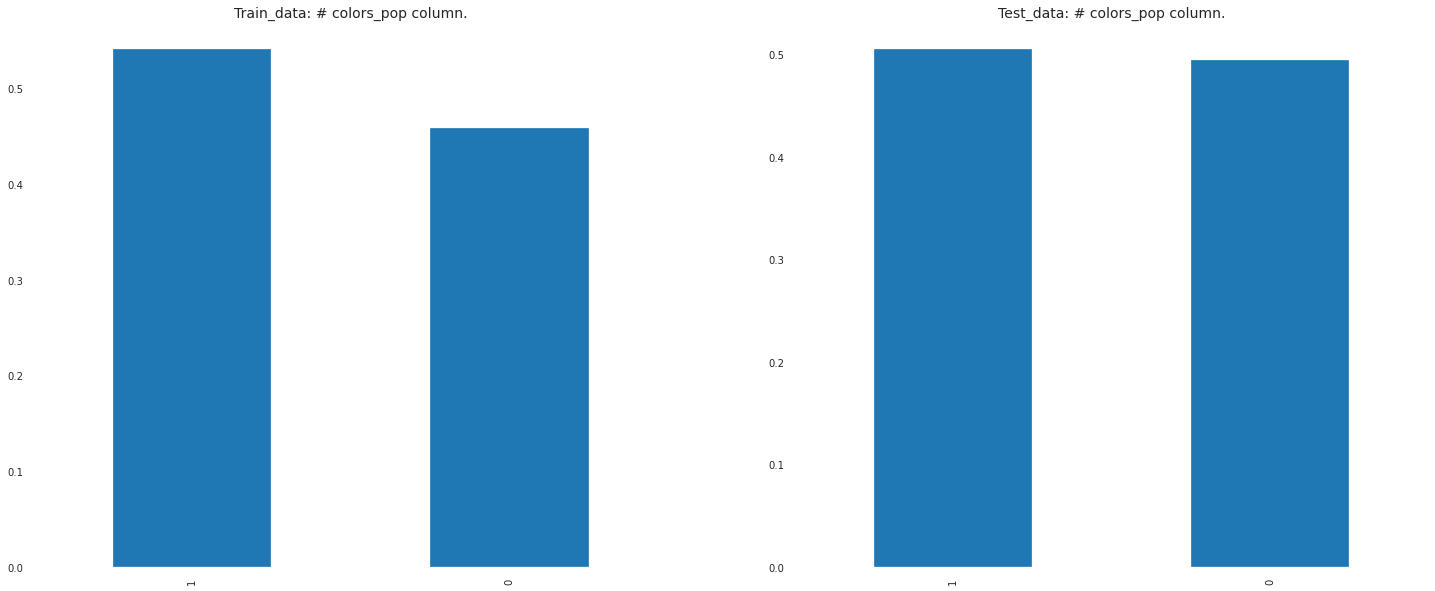

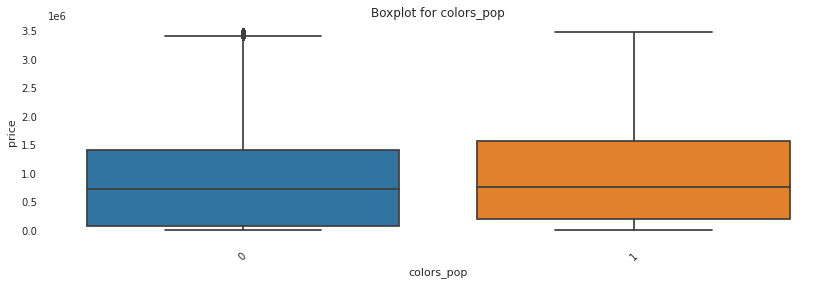

______________________________________________________________________________________________________________________________________________________




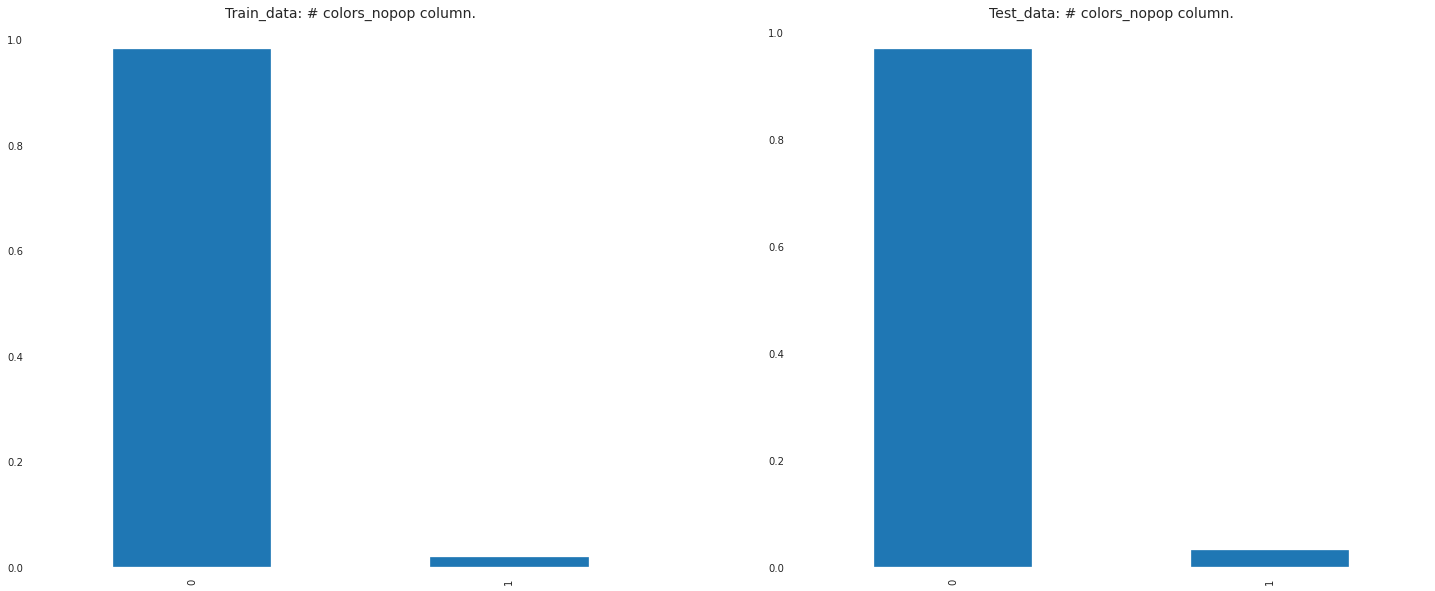

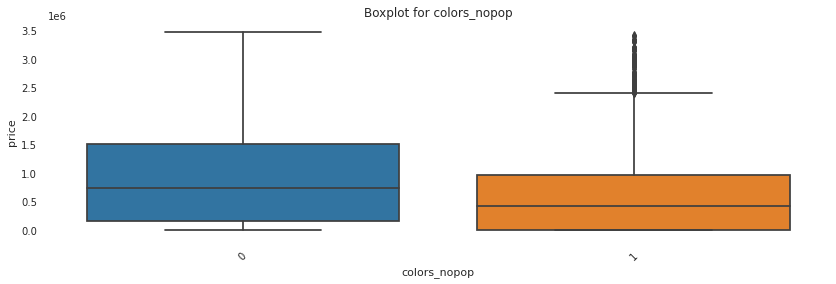

______________________________________________________________________________________________________________________________________________________




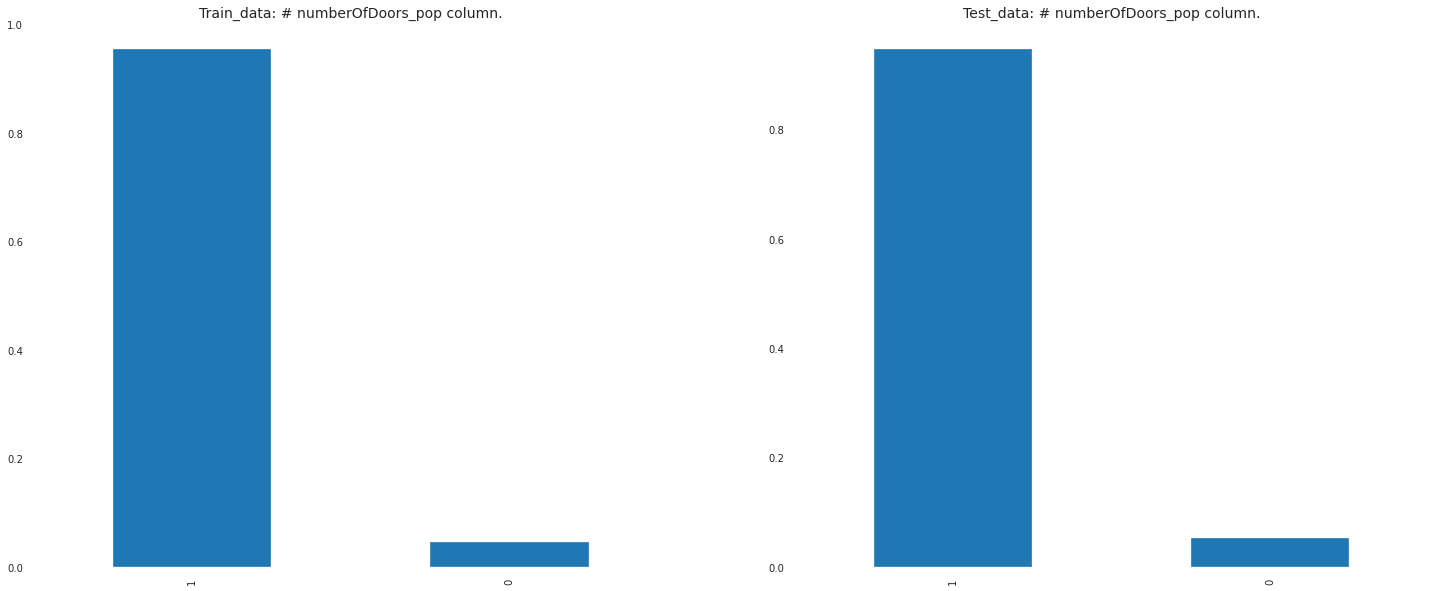

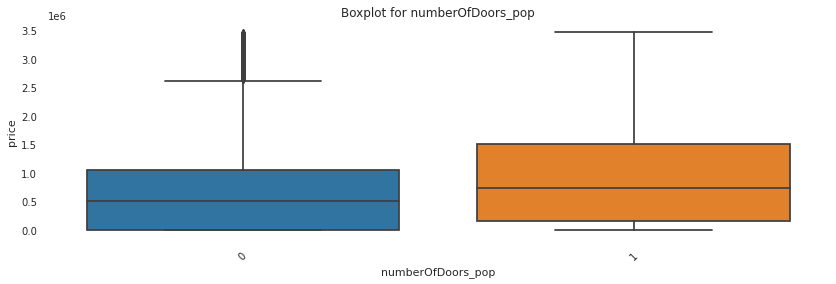

______________________________________________________________________________________________________________________________________________________




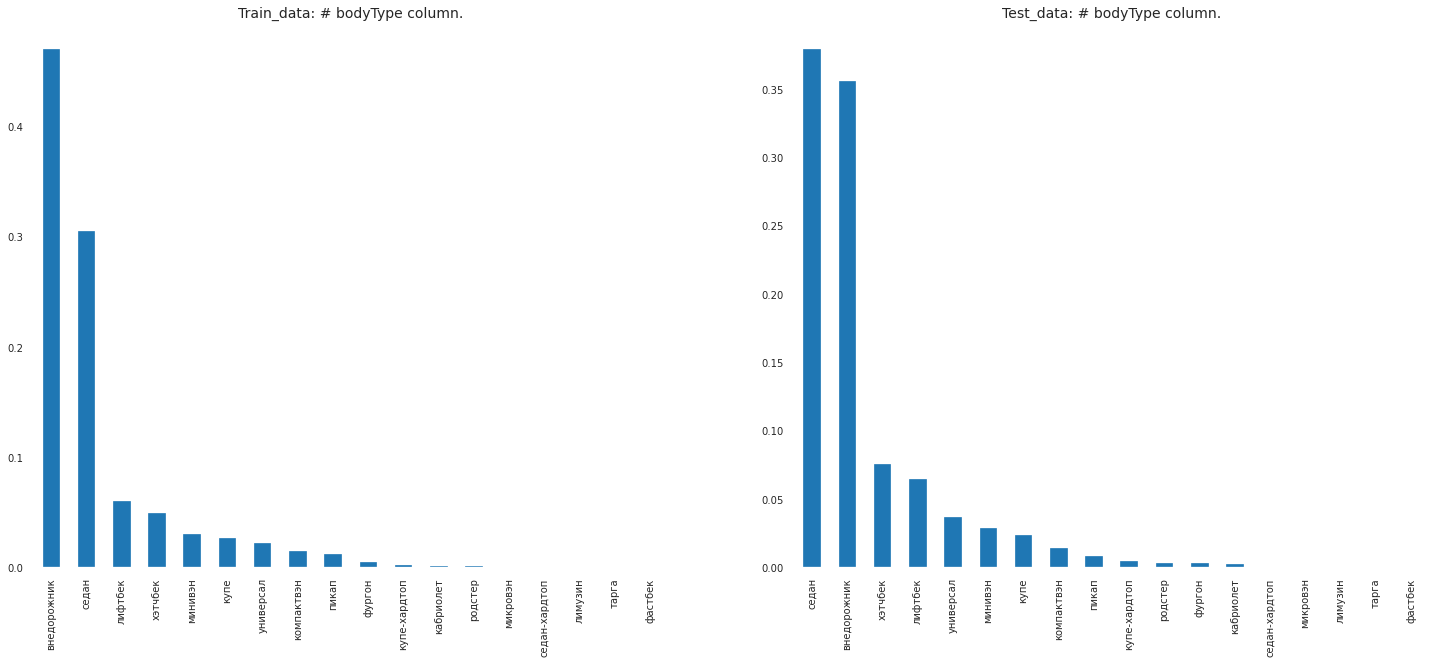

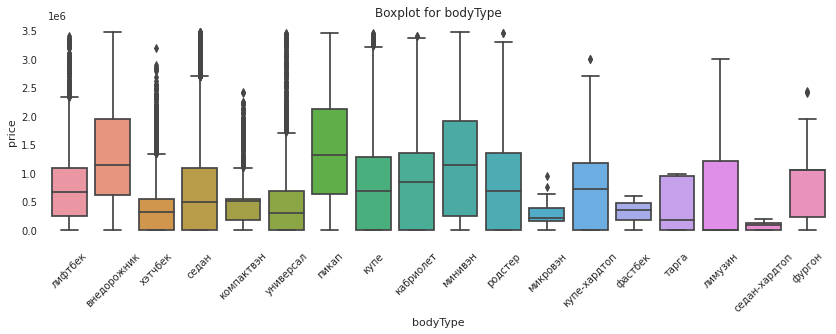

______________________________________________________________________________________________________________________________________________________




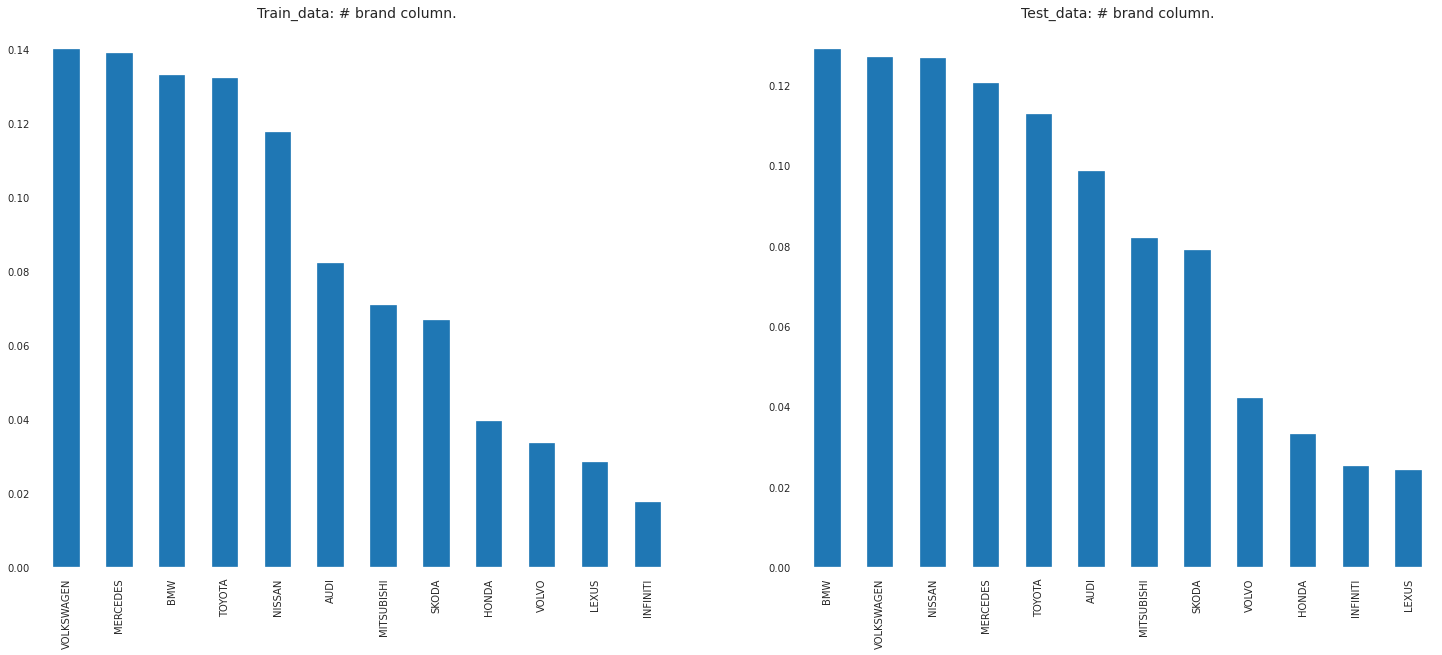

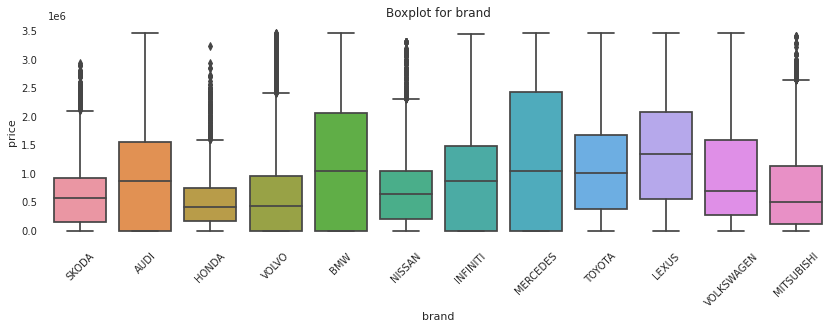

______________________________________________________________________________________________________________________________________________________




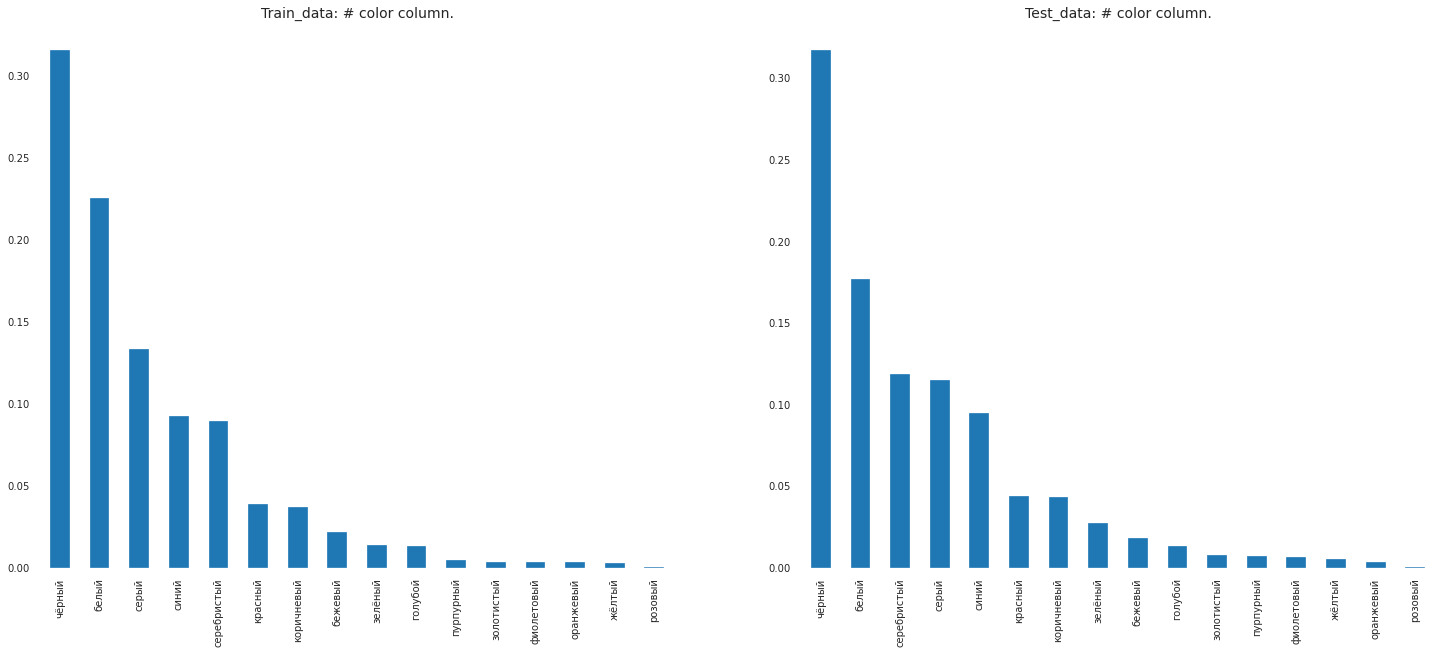

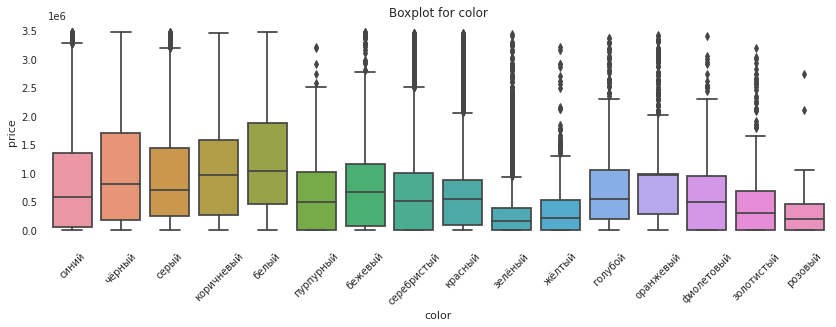

______________________________________________________________________________________________________________________________________________________




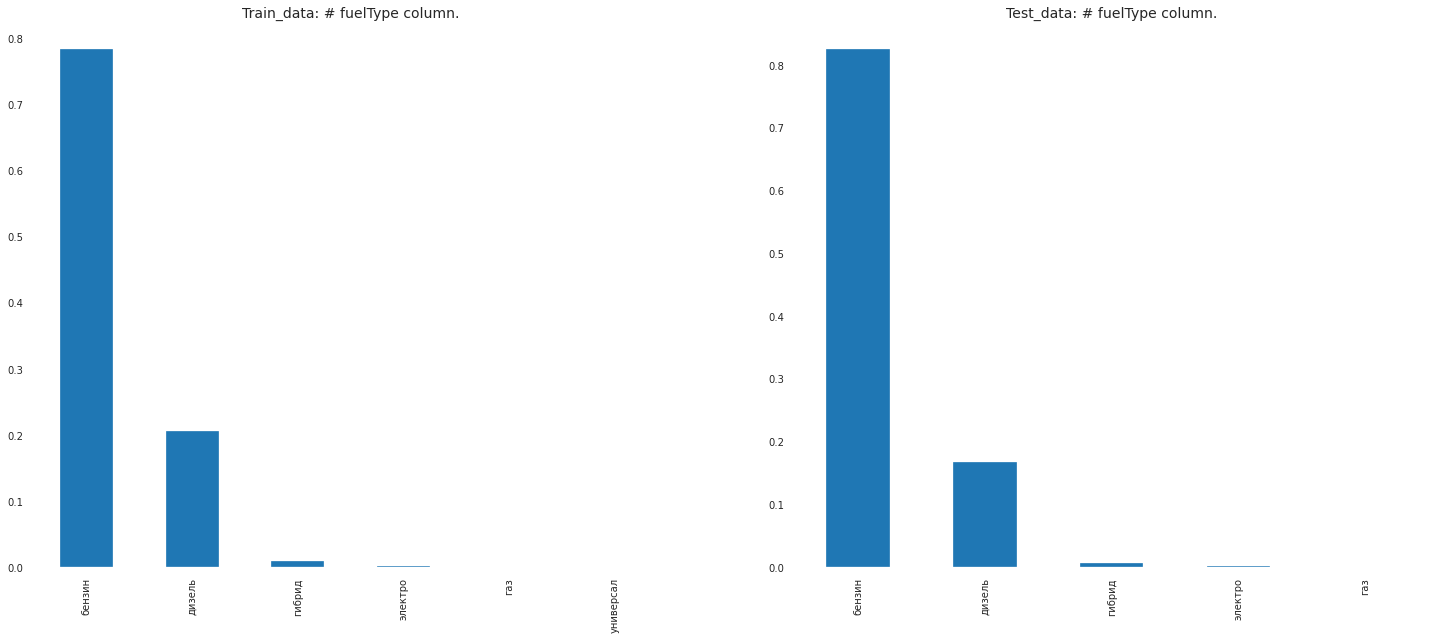

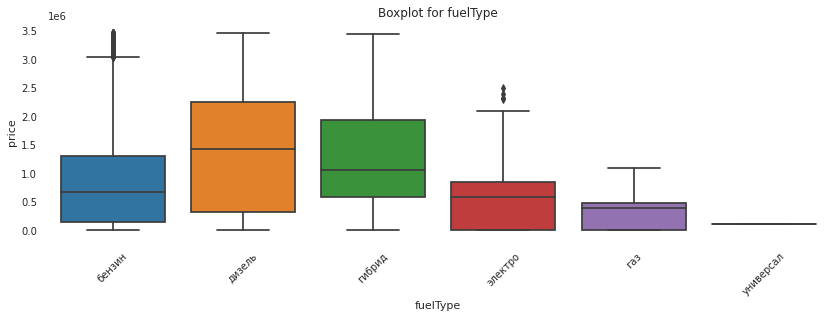

______________________________________________________________________________________________________________________________________________________




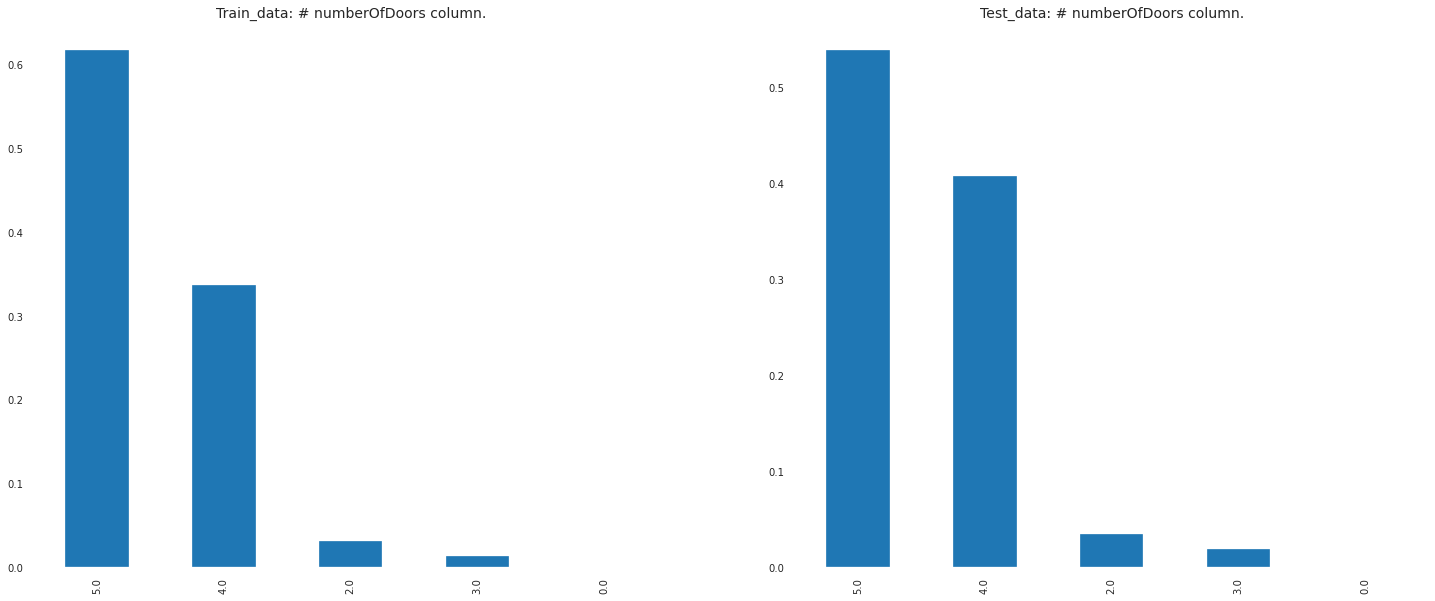

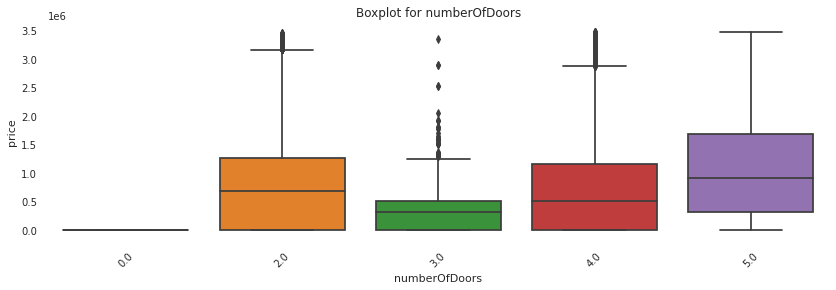

______________________________________________________________________________________________________________________________________________________




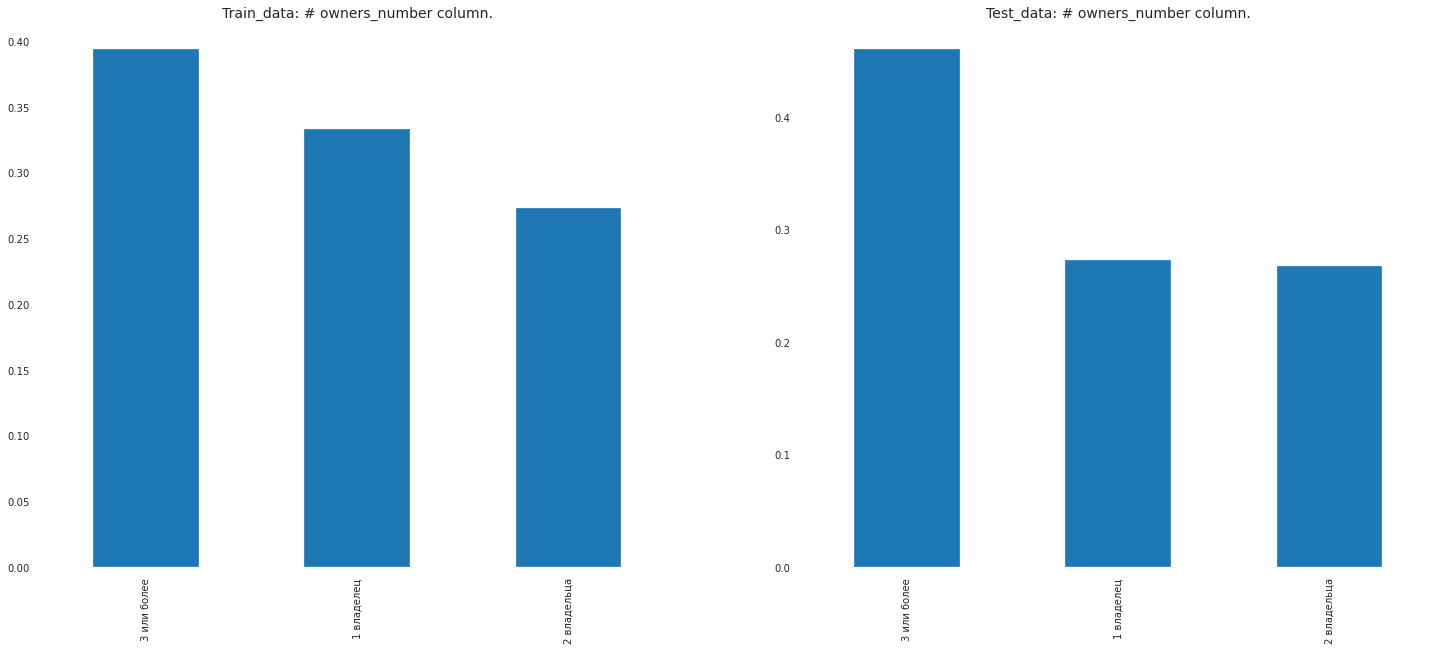

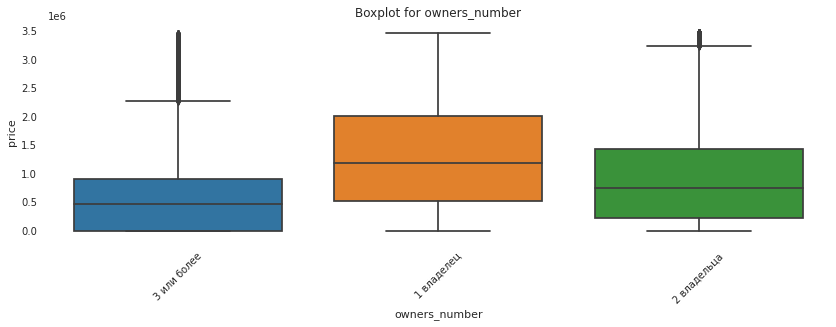

______________________________________________________________________________________________________________________________________________________




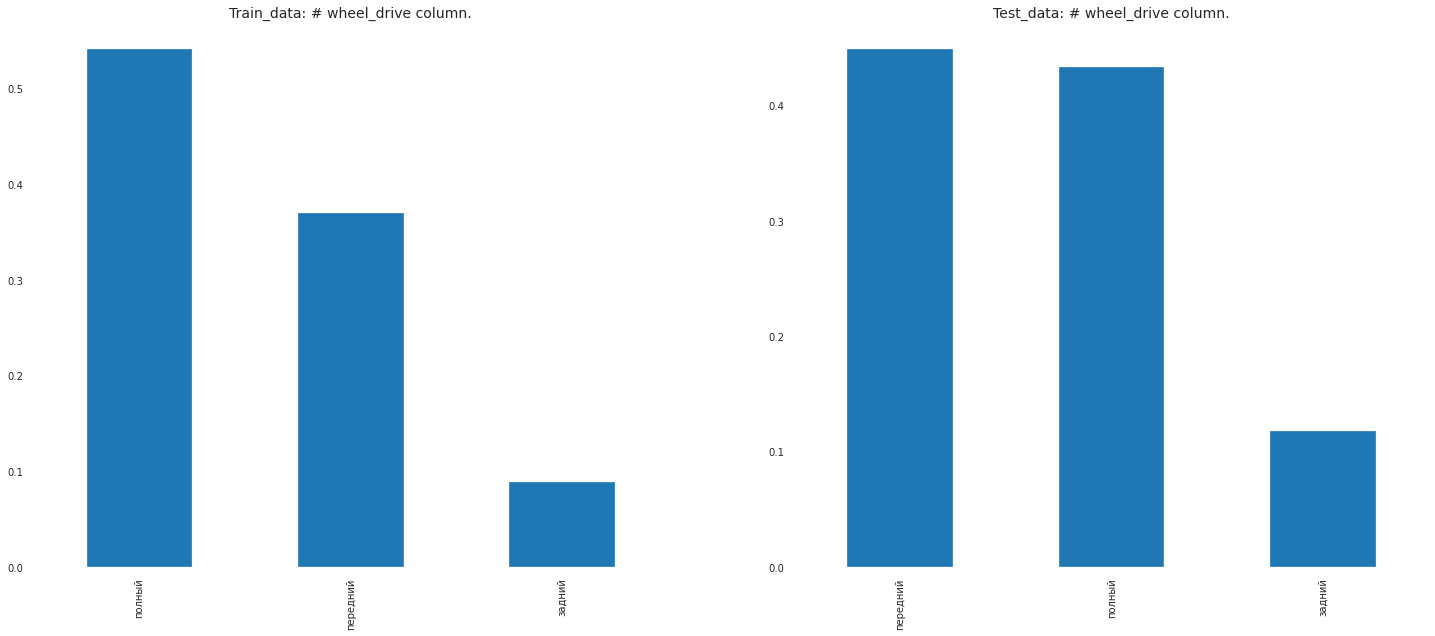

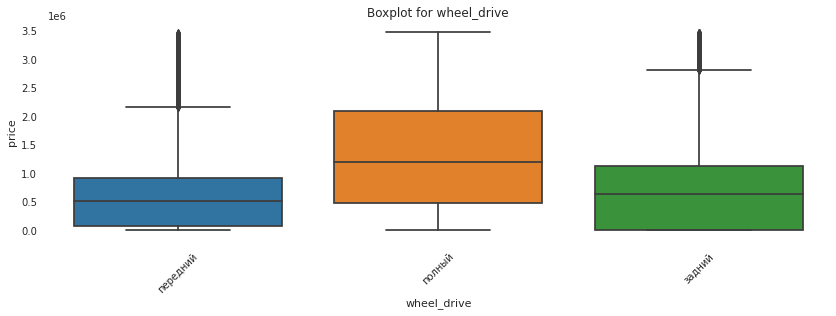

______________________________________________________________________________________________________________________________________________________




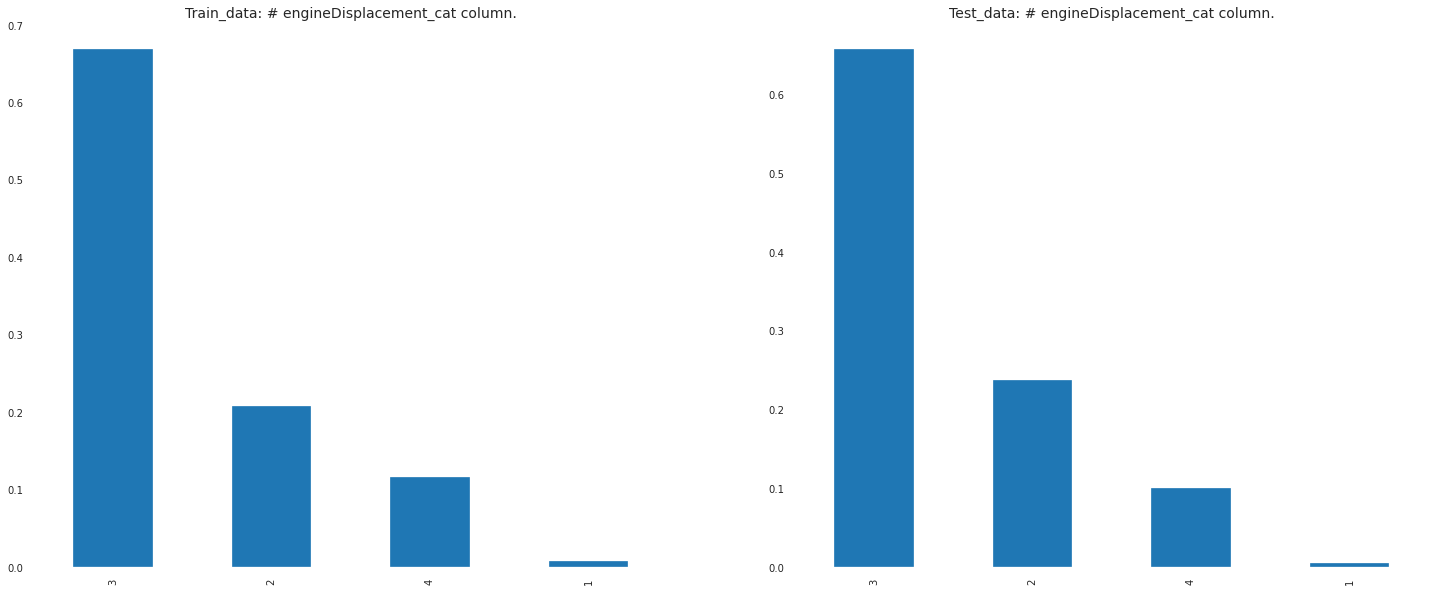

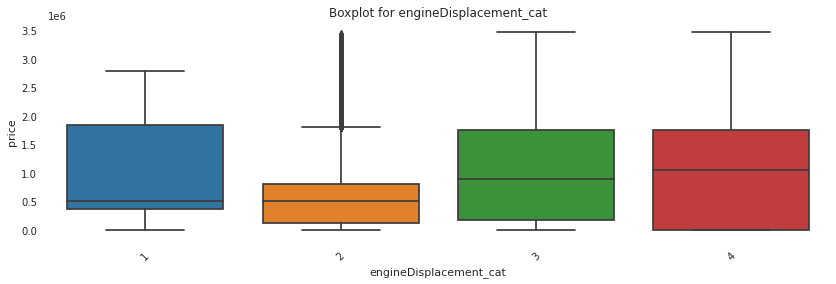

______________________________________________________________________________________________________________________________________________________




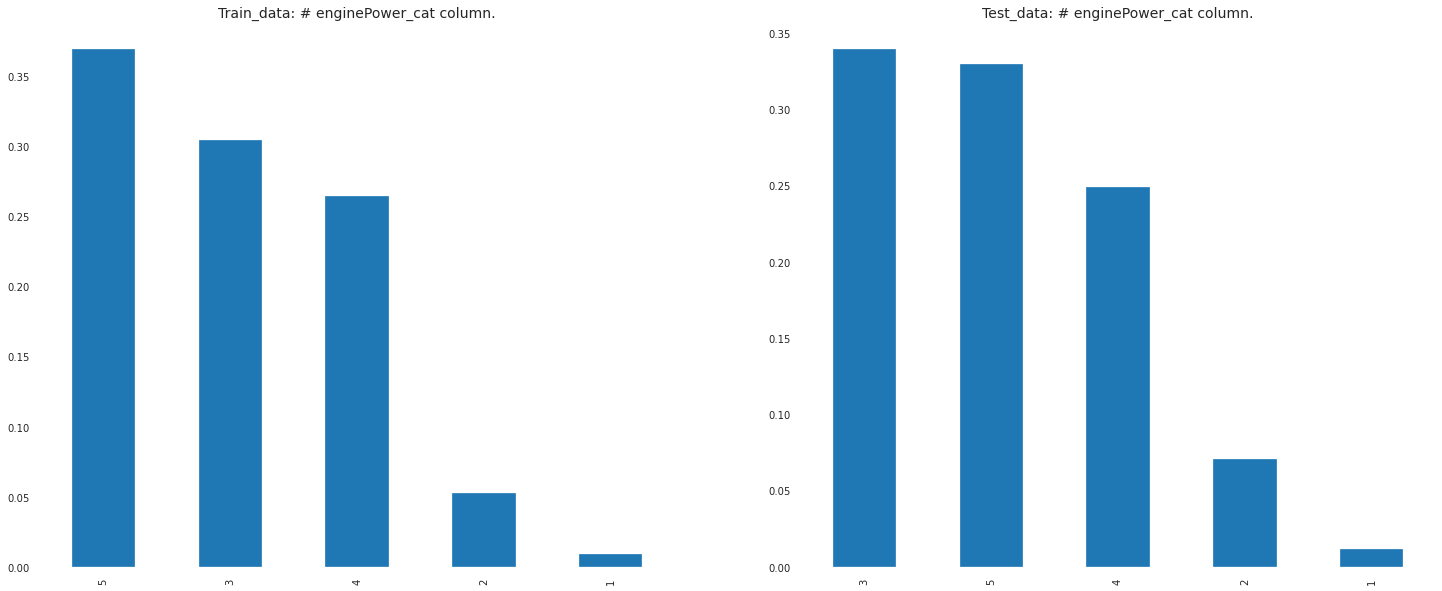

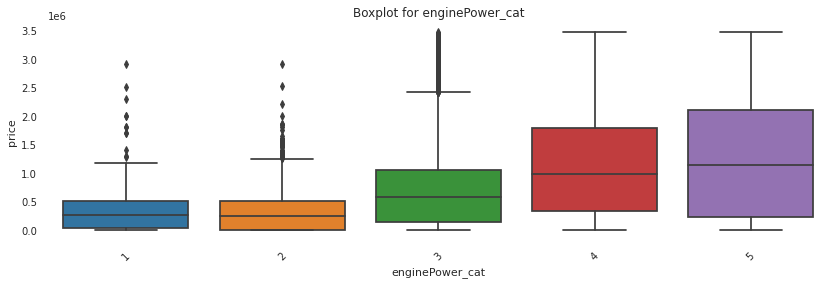

______________________________________________________________________________________________________________________________________________________




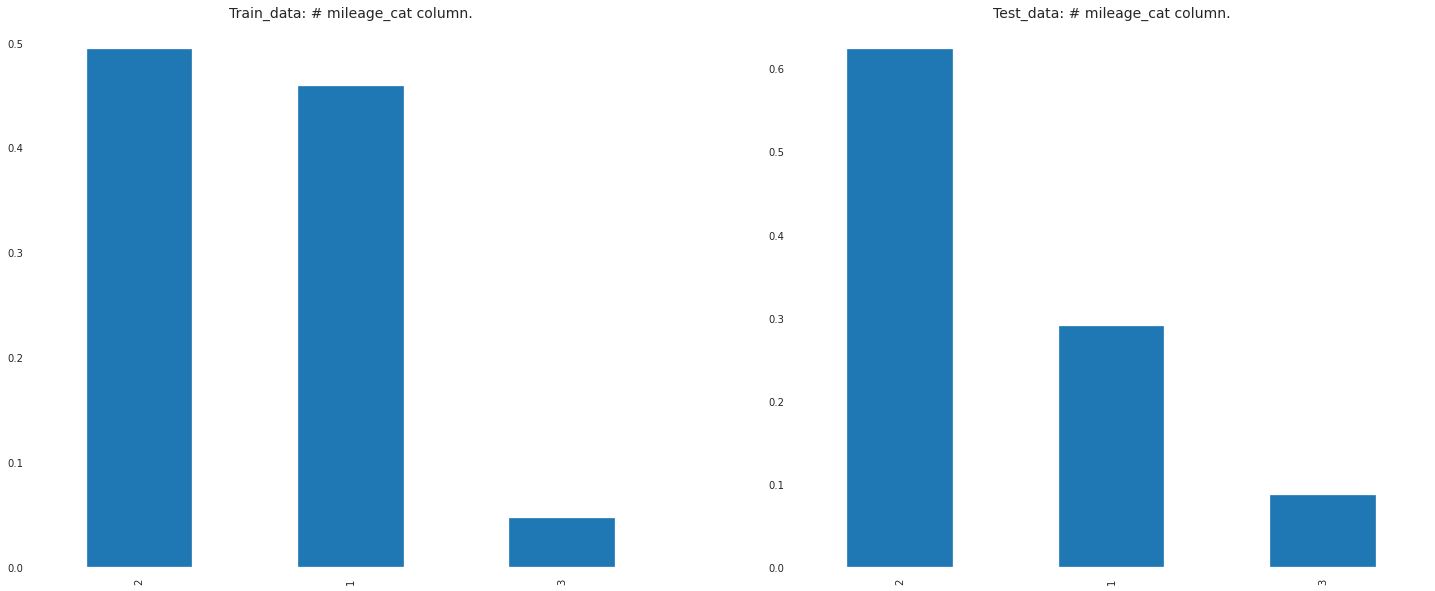

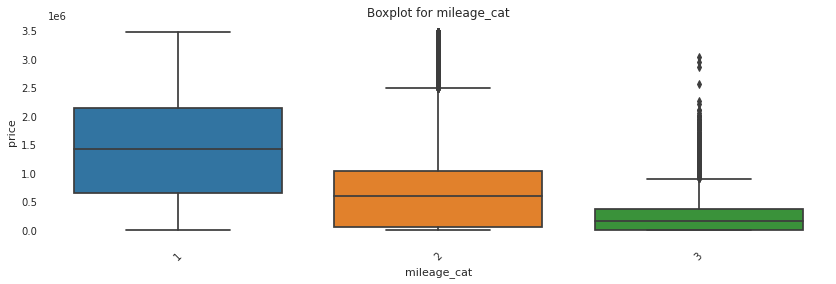

______________________________________________________________________________________________________________________________________________________




In [78]:
for col in bin_cols + cat_cols:
    if col not in ['model_name']: 
        fig, ax = plt.subplots(figsize=(25, 10), ncols=2, nrows=1)
        ax[0].set_title(f'Train_data: # {col} column.', fontdict={'fontsize': 14})
        all_data[all_data.train == 1][col].value_counts(normalize=True).plot(kind='bar', ax=ax[0])
        ax[1].set_title(f'Test_data: # {col} column.', fontdict={'fontsize': 14})
        all_data[all_data.train == 0][col].value_counts(normalize=True).plot(kind='bar', ax=ax[1])
        # из-за выбросов в price нужно взять 90% квантиль, чтобы боксплоты были читаемы
        show_boxplot(data=all_data[all_data.price <= all_data.price.quantile(0.9)], column=col, target_column='price')
        print('_' * 150)
        print('\n')
        plt.show()

In [79]:
all_data['mpy'] = all_data.productionDate / all_data.mileage
all_data['mpy'].replace([np.inf, -np.inf], 0, inplace=True)
# all_data['mpy_log'] = np.log2(all_data.mpy+1)
all_data['age'] = 2021 - all_data.productionDate
all_data['age'].replace([np.inf, -np.inf], 0, inplace=True)
all_data['age_log'] = np.log2(all_data.age+1)
all_data['time_model'] = all_data.productionDate - all_data.modelDate
all_data.loc[all_data.time_model < 0, 'time_model'] = 0
all_data['time_model_log'] = np.log2(all_data.time_model+1)
# all_data['enginePower_log'] = np.log2(all_data.enginePower+1)
# all_data['enginePower_log'].replace([np.inf, -np.inf], 0, inplace=True)
# all_data['mileage_log'] = np.log2(all_data.mileage+1)
# all_data['mileage_log'].replace([np.inf, -np.inf], 0, inplace=True)
num_cols.extend(['mpy','time_model_log'])
num_cols.remove('modelDate')
num_cols.remove('productionDate')
num_cols.remove('enginePower')
all_data.drop('modelDate', axis=1, inplace=True)
all_data.drop('productionDate', axis=1, inplace=True)
all_data.drop('enginePower', axis=1, inplace=True)
all_data.drop('age', axis=1, inplace=True)
all_data.drop('age_log', axis=1, inplace=True)
all_data.drop('time_model', axis=1, inplace=True)

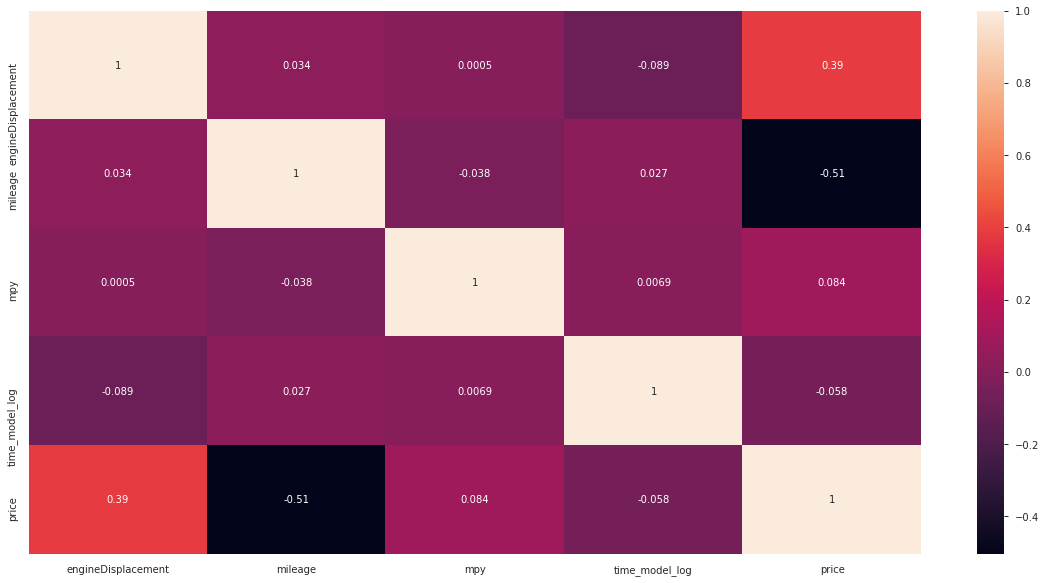

In [80]:
plt.figure(figsize=(20, 10));
sns.heatmap(all_data[all_data.train == 1][num_cols + ['price']].corr(), annot=True);

In [90]:
all_data.dropna(inplace=True)

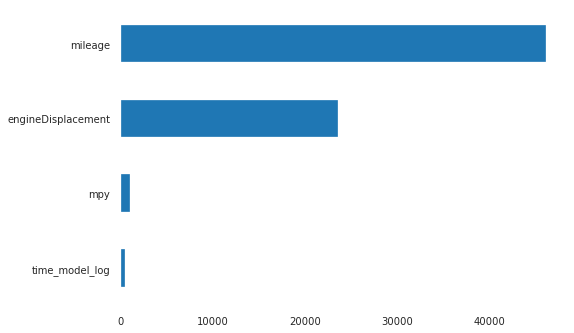

In [91]:
imp_num = pd.Series(f_regression(all_data[all_data.train == 1][num_cols], all_data[all_data.train == 1]['price'])[0],
                    index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [85]:
for col in ['steering_wheel', 'vehicleTransmission', 'vendor', 'vehicle_licence']:
    all_data[col] = all_data[col].astype('category').cat.codes
all_cols = list(set(all_data.columns) & set(cat_cols))
for col in all_cols:
    all_data[col] = all_data[col].astype('category').cat.codes 

In [86]:
all_data.drop('vehicleConfiguration', axis=1, inplace=True)

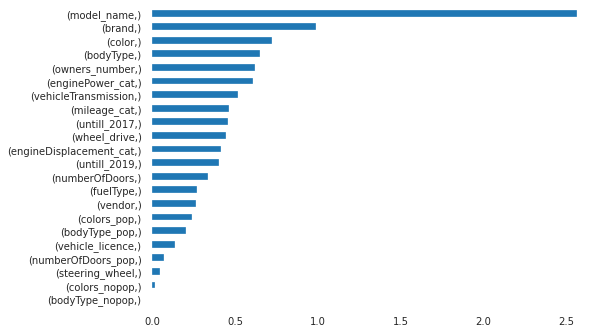

In [87]:
imp_cat = pd.Series(mutual_info_regression(all_data[all_data.train == 1][list(set(all_data.columns) & set(cat_cols+bin_cols))], 
                                        all_data[all_data.train == 1]['price'], discrete_features=True), 
                                        index=[list(set(all_data.columns) & set(cat_cols+bin_cols))])
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

In [88]:
X = all_data.query('train == 1').drop(['price', 'train', 'parsing_date'], axis=1)
X_sub = all_data.query('train == 0').drop(['price', 'train', 'parsing_date'], axis=1)
y = all_data.query('train == 1').price

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [92]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# X_sub = scaler.transform(X_sub)

In [93]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.




In [94]:
# tmp_train = X_train.copy()
# tmp_train['price'] = y_train

In [95]:
# # Находим median по экземплярам engineDisplacement в трейне и размечаем тест
# predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())

# #оцениваем точность
# print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 86.23%

# Model 2: CatBoost 

In [96]:
# model = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )
# model.fit(X_train, y_train,
#          #cat_features=cat_features_ids,
#          eval_set=(X_test, y_test),
#          verbose_eval=0,
#          use_best_model=True,
#          #plot=True
#          )

# model.save_model('catboost_single_model_baseline.model')

In [97]:
# # оцениваем точность
# predict = model.predict(X_test)
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 14.70%

### Log Traget

In [98]:
# CBR = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )

# model.fit(X_train, np.log(y_train),
#          #cat_features=cat_features_ids,
#          eval_set=(X_test, np.log(y_test)),
#          verbose_eval=0,
#          use_best_model=True,
#          #plot=True
#          )

# model.save_model('catboost_model_2_basel.model')

Точность модели по метрике MAPE: 11.65%

In [99]:
# model = CatBoostRegressor(iterations = 50,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )

# grid = {
#     'learning_rate': [0.03, 0.05, 0.1],
#     'depth': [2, 4, 6],
#     'l2_leaf_reg': [1, 3, 5, 7, 9],
#     'iterations': [int(x) for x in np.linspace(start=1000, stop=5000, num=20)]
# } 

# grid_search_result = model.grid_search(
#     grid,
#     X=X_train,
#     y=np.log(y_train),
#     #plot=True
# )
# print('\nпараметры: ', grid_search_result['params'])

# {'depth': 6, 'l2_leaf_reg': 1, 'iterations': 5000, 'learning_rate': 0.1}

# CBR_hyp = CatBoostRegressor(iterations = 5000,
#                        random_seed = RANDOM_SEED,
#                        eval_metric='MAPE',
#                        custom_metric=['R2', 'MAE'],
#                        silent=True,
#                        learning_rate=0.1, 
#                        depth=6,
#                        l2_leaf_reg=1)


# CBR_hyp.fit(X_train, np.log(y_train),
#          #cat_features=cat_features_ids,
#          eval_set=(X_test, np.log(y_test)),
#          verbose_eval=0,
#          use_best_model=True,
#          #plot=True
#          )

# CBR_hyp.save_model('catboost_grid_search.model')
# predict_test = np.exp(CBR_hyp.predict(X_test))
# predict_submission = np.exp(CBR_hyp.predict(X_sub))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 10.52%, LB - 17.88246

# Model 3: Random Forest 

In [100]:
# RF = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
# RF.fit(X_train, np.log(y_train))


# predict_test = np.exp(RF.predict(X_test))
# predict_submission = np.exp(RF.predict(X_sub))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 11.31%, LB - 17.83502

In [101]:
# hp.uniform('n_estimators',100,500),
# hp.choice("n_estimators", [int(x) for x in np.linspace(200, 1000, num = 17)])

# def objective(params):
#     model=RandomForestRegressor(
#         n_estimators=int(params['n_estimators']),
#         max_depth=int(params['max_depth']),
#         min_samples_leaf=int(params['min_samples_leaf']),
#         min_samples_split=int(params['min_samples_split']),
#         bootstrap=params['bootstrap'],
#         max_features=params['max_features'],
#         random_state=RANDOM_SEED,
#         n_jobs=-1
#     )
#     model.fit(X_train, np.log(y_train))
#     pred=model.predict(X_test)
#     score=mape(y_test,np.exp(pred))
#     return score

# def optimize(trial):
#     params={
#         'n_estimators': hp.uniform('n_estimators',100,500),
#         'max_features': hp.choice("max_features", ['auto', 'sqrt']),
#         'max_depth': hp.uniform('max_depth',5,15),
#         'min_samples_split': hp.uniform('min_samples_split',2,10),
#         'min_samples_leaf': hp.uniform('min_samples_leaf',1,5),
#         'bootstrap': hp.choice("bootstrap", [True, False])
#     }
#     best=fmin(fn=objective, space=params, algo=tpe.suggest, trials=trial, max_evals=100, rstate=np.random.RandomState(RANDOM_SEED))
#     return best

# trial=Trials()
# best=optimize(trial)
# print(best)

# {'bootstrap': 0, 'max_depth': 13.285622441991428, 'max_features': 0, 'min_samples_leaf': 1.2149894134608765, 
#  'min_samples_split': 7.177767056952717, 'n_estimators': 318.016345894408}

In [102]:
# random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 4)],
#                'max_features': ['auto', 'sqrt'],
#                'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
#                'min_samples_split': [2, 5, 10],
#                'min_samples_leaf': [1, 2, 4],
#                'bootstrap': [True, False]}
# RF = RandomForestRegressor(random_state = RANDOM_SEED)
# RF_search = RandomizedSearchCV(estimator = RF, 
#                                param_distributions = random_grid, 
#                                n_iter = 100, 
#                                cv = 3, 
#                                verbose=10, 
#                                random_state=RANDOM_SEED, 
#                                n_jobs = -1)
# RF_search.fit(X_train, np.log(y_train))
# RF_search.best_params_

# {'n_estimators': 300,
#  'min_samples_split': 10,
#  'min_samples_leaf': 1,
#  'max_features': 'sqrt',
#  'max_depth': None,
#  'bootstrap': False}

In [103]:
# RF_hyp = RandomForestRegressor(random_state=RANDOM_SEED, 
#                                    n_jobs=-1, 
#                                    verbose=1, 
#                                    n_estimators = 300, 
#                                    min_samples_split = 10, 
#                                    min_samples_leaf = 1, 
#                                    max_features = 'sqrt', 
#                                    max_depth = 10, 
#                                    bootstrap = False)
# RF_hyp.fit(X_train, np.log(y_train))


# predict_test = np.exp(RF_hyp.predict(X_test))
# predict_submission = np.exp(RF_hyp.predict(X_sub))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.81%, LB - 24.41888 

# Model 3: Extra Trees 

In [104]:
# ETR = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)

# ETR.fit(X_train, np.log(y_train))

# predict_test = np.exp(ETR.predict(X_test))
# predict_submission = np.exp(ETR.predict(X_sub))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 11.16%, LB - 15.80479

In [105]:
# hp.uniform('n_estimators',100,500),
# hp.choice("n_estimators", [int(x) for x in np.linspace(200, 1000, num = 17)])

# def objective(params):
#     model=ExtraTreesRegressor(
#         n_estimators=int(params['n_estimators']),
#         max_depth=int(params['max_depth']),
#         min_samples_leaf=int(params['min_samples_leaf']),
#         min_samples_split=int(params['min_samples_split']),
#         bootstrap=params['bootstrap'],
#         max_features=params['max_features'],
#         random_state=RANDOM_SEED,
#         n_jobs=-1
#     )
#     model.fit(X_train, np.log(y_train))
#     pred=model.predict(X_test)
#     score=mape(y_test,np.exp(pred))
#     return score

# def optimize(trial):
#     params={
#         'n_estimators': hp.uniform('n_estimators',100,500),
#         'max_features': hp.choice("max_features", ['auto', 'sqrt']),
#         'max_depth': hp.uniform('max_depth',5,15),
#         'min_samples_split': hp.uniform('min_samples_split',2,10),
#         'min_samples_leaf': hp.uniform('min_samples_leaf',1,5),
#         'bootstrap': hp.choice("bootstrap", [True, False])
#     }
#     best=fmin(fn=objective, space=params, algo=tpe.suggest, trials=trial, max_evals=100, rstate=np.random.RandomState(RANDOM_SEED))
#     return best

# trial=Trials()
# best=optimize(trial)
# print(best)
# {'bootstrap': 1, 'max_depth': 14.788793391632602, 'max_features': 0, 'min_samples_leaf': 1.2997328671331532, 
#  'min_samples_split': 2.3466790481322, 'n_estimators': 458.28454045832717}

In [106]:
# ETR_hyp = ExtraTreesRegressor(random_state=RANDOM_SEED, 
#                                    n_jobs=-1, 
#                                    verbose=1, 
#                                    n_estimators = 458, 
#                                    min_samples_split = 2, 
#                                    min_samples_leaf = 1, 
#                                    max_features = 'auto', 
#                                    max_depth = 14.79, 
#                                    bootstrap = False)

# ETR_hyp.fit(X_train, np.log(y_train))

# predict_test = np.exp(ETR_hyp.predict(X_test))
# predict_submission = np.exp(ETR_hyp.predict(X_sub))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.68%, LB 23.62

# Model 4: Gradient Boosting

In [107]:
# GB = GradientBoostingRegressor(random_state=RANDOM_SEED)
# GB.fit(X_train, np.log(y_train))


# predict_test = np.exp(GB.predict(X_test))
# predict_submission = np.exp(GB.predict(X_sub))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 23.17%

In [108]:
# random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 8)],
#                'max_features': ['auto', 'sqrt', 'log2'],
#                'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
#                'min_samples_split': [2, 5, 10],
#                'min_samples_leaf': [1, 2, 4]}

# GB = GradientBoostingRegressor()
# GB_search = RandomizedSearchCV(estimator = GB,
#                                param_distributions = random_grid,
#                                n_iter = 100,
#                                cv = 3,
#                                verbose=10,
#                                random_state=RANDOM_SEED,
#                                n_jobs = -1)
# GB_search.fit(X_train, np.log(y_train))
# GB_search.best_params_

# {'n_estimators': 400,
#  'min_samples_split': 5,
#  'min_samples_leaf': 2,
#  'max_features': 'auto',
#  'max_depth': 9}

In [109]:
# GBR_hyp = GradientBoostingRegressor(random_state=RANDOM_SEED,
#                                               n_estimators=400,
#                                               min_samples_split=5,
#                                               min_samples_leaf=2,
#                                               max_features='auto',
#                                               max_depth=9)
# GBR_hyp.fit(X_train, np.log(y_train))

# predict_test = np.exp(GBR_hyp.predict(X_test))
# predict_submission = np.exp(GBR_hyp.predict(X_sub))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 10.34%, LB - 16.83837

# Model 5 : XGBoost

In [110]:
# XGBR = xgb.XGBRegressor(
#     objective='reg:squarederror', 
#     colsample_bytree=0.5,               
#     learning_rate=0.05, 
#     max_depth=12, 
#     alpha=1,                   
#     n_estimators=1000,
#     random_state=RANDOM_SEED,
#     verbose=1, 
#     n_jobs=-1
# )

# XGBR.fit(X_train, np.log(y_train))

# predict_test = np.exp(XGBR.predict(X_test))
# predict_submission = np.exp(XGBR.predict(X_sub))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 9.71%, LB - 15.98611

# Model 6 : CatBoost Bagging

In [112]:
# BR_CBR_hyp =  BaggingRegressor(CBR_hyp, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
# BR_CBR_hyp.fit(X_train, np.log(y_train))

# predict_test = np.exp(BR_CBR_hyp.predict(X_test))
# predict_submission = np.exp(BR_CBR_hyp.predict(X_sub))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 10.54%, LB - 18.40113

# Model 7 : Random Forest Bagging

In [113]:
# BR_RF =  BaggingRegressor(RF, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
# BR_RF.fit(X_train, np.log(y_train))

# predict_test = np.exp(BR_RF.predict(X_test))
# predict_submission = np.exp(BR_RF.predict(X_sub))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 11.72%, LB - 19.83994

# Model 8 : Extra Trees Bagging

In [114]:
# BR_ETR =  BaggingRegressor(ETR, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
# BR_ETR.fit(X_train, np.log(y_train))

# predict_test = np.exp(BR_ETR.predict(X_test))
# predict_submission = np.exp(BR_ETR.predict(X_sub))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 11.52% - LB 18.15229 

# Model 9 : Gradient Boosting Bagging

In [115]:
# BR_GBR_hyp =  BaggingRegressor(GBR_hyp, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
# BR_GBR_hyp.fit(X_train, np.log(y_train))

# predict_test = np.exp(BR_GBR_hyp.predict(X_test))
# predict_submission = np.exp(BR_GBR_hyp.predict(X_sub))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 10.44%, LB - 17.61038

# Model 10 : XGBoost Bagging

In [116]:
# BR_XGBR =  BaggingRegressor(XGBR, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
# BR_XGBR.fit(X_train, np.log(y_train))

# predict_test = np.exp(BR_XGBR.predict(X_test))
# predict_submission = np.exp(BR_XGBR.predict(X_sub))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 10.00%, LB - 17.04728

# Model 11 : StackingRegressor

In [117]:
estimators = [
    ('etr', ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)),
    ('xgb', xgb.XGBRegressor(
    objective='reg:squarederror', 
    colsample_bytree=0.5,               
    learning_rate=0.05, 
    max_depth=12, 
    alpha=1,                   
    n_estimators=1000,
    random_state=RANDOM_SEED,
    verbose=1, 
    n_jobs=-1
))]

SR_1 = StackingRegressor(
    estimators=estimators,
    cv=cv,
    verbose=10,
    passthrough=True,
    n_jobs=-1,
    final_estimator=LinearRegression()
)

SR_1.fit(X_train, np.log(y_train))

predict_test = np.exp(SR_1.predict(X_test))
predict_submission = np.exp(SR_1.predict(X_sub))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


Точность модели по метрике MAPE: 9.74%


Точность модели по метрике MAPE: 9.74%, LB 15.69722 

In [118]:
# estimators = [
#     ('etr', ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)),
# ]

# SR_1 = StackingRegressor(
#     estimators=estimators,
#     final_estimator=xgb.XGBRegressor(
#     objective='reg:squarederror', 
#     colsample_bytree=0.5,               
#     learning_rate=0.05, 
#     max_depth=12, 
#     alpha=1,                   
#     n_estimators=1000,
#     random_state=RANDOM_SEED,
#     verbose=1, 
#     n_jobs=-1
# )
# )

# SR_1.fit(X_train, np.log(y_train))

# predict_test = np.exp(SR_1.predict(X_test))
# predict_submission = np.exp(SR_1.predict(X_sub))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 11.63%

In [119]:
# estimators = [
#         ('xgbr', xgb.XGBRegressor(
#     objective='reg:squarederror', 
#     colsample_bytree=0.5,               
#     learning_rate=0.05, 
#     max_depth=12, 
#     alpha=1,                   
#     n_estimators=1000,
#     random_state=RANDOM_SEED,
#     n_jobs=-1))
# ]

# SR_1 = StackingRegressor(
#     estimators=estimators,
#     final_estimator=ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
# )


# SR_1.fit(X_train, np.log(y_train))

# predict_test = np.exp(SR_1.predict(X_test))
# predict_submission = np.exp(SR_1.predict(X_sub))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 17.54%

In [120]:
# estimators = [
#     ('etr', ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)),
#     ('xgb', xgb.XGBRegressor(
#     objective='reg:squarederror', 
#     colsample_bytree=0.5,               
#     learning_rate=0.05, 
#     max_depth=12, 
#     alpha=1,                   
#     n_estimators=1000,
#     random_state=RANDOM_SEED, 
#     n_jobs=-1
# ))]

# SR_1 = StackingRegressor(
#     estimators=estimators,
#     final_estimator=GradientBoostingRegressor(random_state=RANDOM_SEED,
#                                               n_estimators=400,
#                                               min_samples_split=5,
#                                               min_samples_leaf=2,
#                                               max_features='auto',
#                                               max_depth=9)
# )

# SR_1.fit(X_train, np.log(y_train))

# predict_test = np.exp(SR_1.predict(X_test))
# predict_submission = np.exp(SR_1.predict(X_sub))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 10.46%

In [121]:
# estimators = [
#     ('etr', ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)),
#     ('gbr', GradientBoostingRegressor(random_state=RANDOM_SEED,
#                                               n_estimators=400,
#                                               min_samples_split=5,
#                                               min_samples_leaf=2,
#                                               max_features='auto',
#                                               max_depth=9))
#    ]

# SR_1 = StackingRegressor(
#     estimators=estimators,
#     final_estimator= (xgb.XGBRegressor(
#     objective='reg:squarederror', 
#     colsample_bytree=0.5,               
#     learning_rate=0.05, 
#     max_depth=12, 
#     alpha=1,                   
#     n_estimators=1000,
#     random_state=RANDOM_SEED, 
#     n_jobs=-1
# )))


# SR_1.fit(X_train, np.log(y_train))

# predict_test = np.exp(SR_1.predict(X_test))
# predict_submission = np.exp(SR_1.predict(X_sub))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 11.17%

In [122]:
# estimators = [
#     ('xgbr', xgb.XGBRegressor(
#     objective='reg:squarederror', 
#     colsample_bytree=0.5,               
#     learning_rate=0.05, 
#     max_depth=12, 
#     alpha=1,                   
#     n_estimators=1000,
#     random_state=RANDOM_SEED, 
#     n_jobs=-1
# )),
#     ('gbr', GradientBoostingRegressor(random_state=RANDOM_SEED,
#                                               n_estimators=400,
#                                               min_samples_split=5,
#                                               min_samples_leaf=2,
#                                               max_features='auto',
#                                               max_depth=9))
#    ]

# SR_1 = StackingRegressor(
#     estimators=estimators,
#     final_estimator= (ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)),)


# SR_1.fit(X_train, np.log(y_train))

# predict_test = np.exp(SR_1.predict(X_test))
# predict_submission = np.exp(SR_1.predict(X_sub))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 12.20%

In [123]:
# estimators = [
#     ('etr', ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)),
#     ]

# SR_1 = StackingRegressor(
#     estimators=estimators,
#     final_estimator=GradientBoostingRegressor(random_state=RANDOM_SEED,
#                                               n_estimators=400,
#                                               min_samples_split=5,
#                                               min_samples_leaf=2,
#                                               max_features='auto',
#                                               max_depth=9))

# SR_1.fit(X_train, np.log(y_train))

# predict_test = np.exp(SR_1.predict(X_test))
# predict_submission = np.exp(SR_1.predict(X_sub))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 11.67%

In [124]:
# estimators = [
#     ('gbr',GradientBoostingRegressor(random_state=RANDOM_SEED,
#                                               n_estimators=400,
#                                               min_samples_split=5,
#                                               min_samples_leaf=2,
#                                               max_features='auto',
#                                               max_depth=9))
#     ]

# SR_1 = StackingRegressor(
#     estimators=estimators,
#     final_estimator=ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1))


# SR_1.fit(X_train, np.log(y_train))

# predict_test = np.exp(SR_1.predict(X_test))
# predict_submission = np.exp(SR_1.predict(X_sub))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 18.25%

# Submission

In [125]:
VERSION = 30
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
sample_submission.head(10)

sell_id         price
0  1100575026  5.963571e+05
1  1100549428  9.136604e+05
2  1100658222  8.691465e+05
3  1100937408  6.958871e+05
4  1101037972  7.591839e+05
5  1100912634  7.101795e+05
6  1101228730  5.856482e+05
7  1100165896  3.781010e+05
8  1100768262  1.826918e+06
9  1101218501  8.714000e+05